# 2. Labeling, structuring and visualizing the data
In this step, we wanted to gain an understanding of how the collected data could inform ML-generated predictions. To do so, we started by organizing and structuring the datasets so that they could be used to create meaningful visualizations, and to enable its interpretation by an algorithm. Where necessary, we added labels that add a layer of meaningful information to the data for the algorithm to use. For the grocery automation case study, we poured the data into a full dataset of all items bought by each individual household. Examples of labels that were added to the data are: an identification of what types of items each item name signified (e.g., "Old Goudse 45+" is cheese); an identification of what type of store the items were bought at (e.g., "Albert Heijn" is a supermarket), and assigning a category to which each item belongs (e.g., milk is a dairy product).

In this notebook we:
1. Import the library/dataframe and recode/add all required variables (2.1 Labeling and structuring)
2. Generate visualizations and correlations to analyze the data (2.2 Visualizing)


<!-- 1. build grid: when do/dont they shop, how many times, on which day...
2. define priliminaries for algorithm
3. define filters for algorithm
4. RUN algorithm 


----


Outcome (example):
1. input: rows of dow shopped
2. output: 0,1,2,0,0,1,0 -->

## 2.1. Labeling and structuring

### Import libraries 

In [3]:
# %matplotlib notebook
%matplotlib inline
#Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
#NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
import dataframe_image as dfi
from datetime import time
import matplotlib.dates as mdates
from matplotlib.ticker import StrMethodFormatter
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from scipy.stats import chi2_contingency

### Load and view data 

In [14]:
df = pd.read_csv (r"/workspaces/Plenty-in-the-Pantry/database/Groceries_onehousehold.csv")
# del df["HH"]
df.describe(include='all')

,HH,week,order_ID,item_id,amount,price_unit,price_total,date,day,timestamp,time,store_type,store_name,promo,item_type,category
count,372.0,372.000000,372.000000,372,372.000000,372.000000,372.000000,372,372,372,372,372,372,372.000000,372,372
unique,NaN,NaN,NaN,314,NaN,NaN,NaN,26,7,35,4,5,9,NaN,126,16
top,NaN,NaN,NaN,GROF BROOD GESN.,NaN,NaN,NaN,2022-01-08,Saturday,17:25:00,morning,supermarket,Okay,NaN,charcuterie,fruit & vegetables
freq,NaN,NaN,NaN,6,NaN,NaN,NaN,45,87,44,186,306,127,NaN,25,103
mean,2.0,4.056452,18.881720,NaN,1.274194,2.602328,2.867247,NaN,NaN,NaN,NaN,NaN,NaN,0.083333,NaN,NaN
std,0.0,2.067470,10.908193,NaN,1.103819,1.947725,2.019200,NaN,NaN,NaN,NaN,NaN,NaN,0.276758,NaN,NaN
min,2.0,1.000000,1.000000,NaN,1.000000,0.064680,0.064680,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,2.0,2.000000,8.000000,NaN,1.000000,1.300000,1.543970,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
50%,2.0,4.000000,20.000000,NaN,1.000000,2.240250,2.462860,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
75%,2.0,5.000000,26.250000,NaN,1.000000,3.290000,3.875000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN


## Recode variables

In [15]:
# new row for reordered items 
df['reorder'] = df.item_type.duplicated()
# convert reorder row to boolean value
df['reorder'] = df['reorder'].astype(bool)
#create an ID for each item 
df.rename(columns={'item_id':'item_name'}, inplace=True)
df['item_id'] = pd.factorize(df['item_name'])[0]
#create an ID for each type 
df['type_id'] = pd.factorize(df['item_type'])[0]
#first make a new column for the amount of items per order
df['order_amount'] = df.groupby('order_ID')['amount'].transform('sum')
# make a new column for the price per order
df['order_price'] = df.groupby('order_ID')['price_total'].transform('sum')

In [16]:
df.dtypes

HH                int64
week              int64
order_ID          int64
item_name        object
amount            int64
price_unit      float64
price_total     float64
date             object
day              object
timestamp        object
time             object
store_type       object
store_name       object
promo             int64
item_type        object
category         object
reorder            bool
item_id           int64
type_id           int64
order_amount      int64
order_price     float64
dtype: object

In [17]:
# Recode object variable types to integers, to enable functions in next cell:
df['week'] = df['week'].astype(int)
df['order_ID'] = df['order_ID'].astype(int)
df['amount'] = df['amount'].astype(int)
df['promo'] = df['promo'].astype(bool)
df['item_id'] = df['item_id'].astype(int)
df['type_id'] = df['type_id'].astype(int)

In [23]:
# Recode categorical values to cat codes:

# Recode dow
df['day_num']=df['day'].astype('category').cat.codes
# Recode store_type
df['storetype_num']=df['store_type'].astype('category').cat.codes
# Recode store_name
df['storename_num']=df['store_name'].astype('category').cat.codes
# Recode categories
df['cat_num']=df['category'].astype('category').cat.codes
# Recode time
df['time_num']=df['time'].astype('category').cat.codes
# Recode time
df['promo_num']=df['promo'].astype('category').cat.codes
df.dtypes

HH                 int64
week               int64
order_ID           int64
item_name         object
amount             int64
price_unit       float64
price_total      float64
date              object
day               object
timestamp         object
time              object
store_type        object
store_name        object
promo               bool
item_type         object
category          object
reorder             bool
item_id            int64
type_id            int64
order_amount       int64
order_price      float64
day_num             int8
storetype_num       int8
storename_num       int8
cat_num             int8
time_num            int8
promo_num           int8
dtype: object

## Save the final dataframe as a new csv file

In [25]:
df.to_csv(r"/workspaces/Plenty-in-the-Pantry/database/Groceries_onehousehold.csv", index=False)
df.drop(["storename_num", 'cat_num', 'time_num', 'promo_num', 'timestamp'], axis=1, inplace=True)
df.drop(['day_num', 'storetype_num', 'reorder'], axis=1, inplace=True)
df.head()

,HH,week,order_ID,item_name,amount,price_unit,price_total,date,day,time,store_type,store_name,promo,item_type,category,item_id,type_id,order_amount,order_price
0,2,1,5,RABEKO choco light 250g,2,2.82,5.64,2021-11-23,Tuesday,noon,supermarket,Okay,False,chocolate spread,breakfast & spreads,0,0,9,16.77
1,2,1,5,JOYVALLE pudding griesmeel natuur 135g,4,0.99,3.96,2021-11-23,Tuesday,noon,supermarket,Okay,False,pudding,dairy & plant based,1,1,9,16.77
2,2,1,5,BONI tomatensoep met balletjes 950ml,1,1.99,1.99,2021-11-23,Tuesday,noon,supermarket,Okay,False,soup,canned foods,2,2,9,16.77
3,2,1,5,LIEBIG DELISOUP 9 groenten brik 1L,1,2.59,2.59,2021-11-23,Tuesday,noon,supermarket,Okay,False,soup,canned foods,3,2,9,16.77
4,2,1,5,LIEBIG DELISOUP tom. Balletjes brik 1L,1,2.59,2.59,2021-11-23,Tuesday,noon,supermarket,Okay,False,soup,canned foods,4,2,9,16.77


## 2.2. Visualizing 

Now that we have a structured dataset, we can visualize it to try to identify patterns in the data, and look for statistical correlations. The patterns that are found in the dataset inform the order in which the predictions would be structured. For instance, once we know on which days the households may shop, we can identify another variable has the highest correlation to the day variable. If that variable would for instance be the type of store, then this becomes the next variable we could look at (i.e., if day is a predictor for store type, subsequently store type may be a predictor for amount of items bought, and so on).

In this section we:
1. Create & export a confusion matrix
2. Analyze visualizations and correlations for all relevant variables

In [ ]:
# use the corr function to display the correlation between all the features
data_corr = df.corr()
data_corr

,week,order_ID,amount,price_unit,price_total,promo,reorder,item_id,type_id,order_amount,order_price,day_num,storetype_num,storename_num,cat_num,time_num,promo_num,timestamp,times_min,dates_days
week,1.000000,0.804654,-0.048140,0.094480,5.483121e-02,-0.008244,0.330432,0.881411,4.026260e-01,-0.253494,-0.154799,0.016479,0.042430,-0.233660,0.129407,0.433118,-0.008244,0.859438,-0.220200,0.771482
order_ID,0.804654,1.000000,0.005611,0.134515,1.293462e-01,0.030952,0.234685,0.706636,3.350350e-01,-0.118124,0.011544,0.048467,0.080177,-0.125979,0.066919,0.410639,0.030952,0.972776,-0.386738,0.799191
amount,-0.048140,0.005611,1.000000,-0.209230,1.654026e-01,-0.048528,0.007978,-0.102130,-8.178184e-02,-0.012262,-0.062144,0.163514,-0.112660,0.171548,-0.298535,0.044981,-0.048528,-0.022860,-0.049977,-0.071387
price_unit,0.094480,0.134515,-0.209230,1.000000,8.995332e-01,0.183813,0.075232,0.106368,4.860249e-02,-0.041801,0.030875,0.071248,0.061079,-0.066105,0.147618,0.083835,0.183813,0.115674,-0.084926,0.083845
price_total,0.054831,0.129346,0.165403,0.899533,1.000000e+00,0.179947,0.069005,0.049907,-1.783440e-07,-0.055200,0.010706,0.133835,0.002398,0.011269,0.013796,0.121559,0.179947,0.096362,-0.126275,0.046190
promo,-0.008244,0.030952,-0.048528,0.183813,1.799472e-01,1.000000,0.030826,-0.018680,8.213454e-02,-0.080867,-0.017922,0.033664,0.136420,-0.234044,0.148676,0.086898,1.000000,0.002949,0.040621,-0.033650
reorder,0.330432,0.234685,0.007978,0.075232,6.900537e-02,0.030826,1.000000,0.237370,-4.185553e-01,-0.308725,-0.246657,0.076217,-0.243438,0.096743,-0.031300,0.264991,0.030826,0.260820,-0.211008,0.256427
item_id,0.881411,0.706636,-0.102130,0.106368,4.990737e-02,-0.018680,0.237370,1.000000,4.876312e-01,-0.158339,-0.034788,0.007337,0.092249,-0.217612,0.190643,0.377275,-0.018680,0.764460,-0.258153,0.711302
type_id,0.402626,0.335035,-0.081782,0.048602,-1.783440e-07,0.082135,-0.418555,0.487631,1.000000e+00,0.159421,0.219891,0.047117,0.348181,-0.249594,0.214586,0.070541,0.082135,0.343415,0.009918,0.275822
order_amount,-0.253494,-0.118124,-0.012262,-0.041801,-5.520033e-02,-0.080867,-0.308725,-0.158339,1.594209e-01,1.000000,0.920146,-0.116226,0.666429,-0.017109,0.130171,-0.379538,-0.080867,-0.163762,0.248016,-0.213740


## 2.2.1. DAYS

### Is there a correlation between day (of week) and week?

In [53]:
df_orders = df[['week', 'order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

In [54]:
# Cross tabulation between DAY and WEEK
CrosstabResult=pd.crosstab(index=df_orders['week'],columns=df_orders['day'])
CrosstabResult

day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
week,,,,,,,
1,1,0,0,0,0,2,1
2,0,0,0,3,2,0,2
3,1,0,1,2,1,0,0
4,0,0,1,3,0,0,1
5,0,2,3,0,0,2,0
6,0,0,1,1,0,1,0
7,0,2,1,0,1,0,0
8,1,2,0,0,1,0,1


In [55]:
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.16141960652205875


There is no correlation: more indication of a pattern?

#### Can we check whether shopping days are predictable over longer time periods?
(e.g.: every two weeks, they go shopping in the weekend)

In [26]:
#Let's try grouping per two (consecutive) dats
df_orders['week'] = df_orders['week'].replace([1, 2], 1)
df_orders['week'] = df_orders['week'].replace([3, 4], 2)
df_orders['week'] = df_orders['week'].replace([5, 6], 3)
df_orders['week'] = df_orders['week'].replace([7, 8], 4)

In [27]:
# Cross tabulation between DAY and WEEK
CrosstabResult=pd.crosstab(index=df_orders['week'],columns=df_orders['day'])

In [28]:
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.20589510072116995


Still significant!
> Let's try even vs uneven weeks

In [29]:
df = pd.read_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2.csv")

df_orders = df[['week','order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

In [30]:
#Let's try grouping per even and uneven weeks
df_orders['week'] = df_orders['week'].replace([1, 3, 5, 7], 1)
df_orders['week'] = df_orders['week'].replace([2, 4, 6, 8], 2)

In [31]:
# Cross tabulation between DAY and WEEK
CrosstabResult=pd.crosstab(index=df_orders['week'],columns=df_orders['day'])
CrosstabResult

day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
week,,,,,,,
1,2,4,5,2,2,4,1
2,1,2,2,7,3,1,4


In [32]:
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.18140198169035493


Not significant!
> Even weeks are not different from uneven weeks

Are the first 4 weeks different from the last 4?

In [33]:
df = pd.read_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2.csv")

df_orders = df[['week','order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

In [34]:
# group per period 1 and 2
df_orders['week'] = df_orders['week'].replace([1, 2, 3, 4], 1)
df_orders['week'] = df_orders['week'].replace([5, 6, 7, 8], 2)

In [35]:
# Cross tabulation between DAY and WEEK
CrosstabResult=pd.crosstab(index=df_orders['week'],columns=df_orders['day'])
CrosstabResult

day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
week,,,,,,,
1,2,0,1,5,3,2,4
2,1,6,6,4,2,3,1


In [36]:
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.0721155900715905


The first period is different from the second period!
> Are the weeks in both periods comparable?

In [37]:
df = pd.read_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2.csv")
df_orders = df[['week','order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

# split up df to first and second period
df_period1 = df_orders[df_orders['week'] < 5]
df_period2 = df_orders[df_orders['week'] > 4]

In [38]:
# Cross tabulation between DAY and WEEK
CrosstabResult1=pd.crosstab(index=df_period1['week'],columns=df_period1['day'])
CrosstabResult2=pd.crosstab(index=df_period2['week'],columns=df_period2['day'])

In [39]:
# Performing Chi-sq test
ChiSqResult1 = chi2_contingency(CrosstabResult1)
ChiSqResult2 = chi2_contingency(CrosstabResult2)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test 1 is:', ChiSqResult1[1])
print('The P-Value of the ChiSq Test 2 is:', ChiSqResult2[1])

The P-Value of the ChiSq Test 1 is: 0.26642044077417815
The P-Value of the ChiSq Test 2 is: 0.5796249574256348


Not significant: the shopping days are quite the same for each period
> In November/December, different from January/February.

## 2.2.2. STORE TYPE/NAME

In [ ]:
df = pd.read_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2.csv")

,week,order_ID,item_name,amount,price_unit,price_total,item_type,category,day,time,...,storename_num,cat_num,time_num,promo_num,datetime,timestamp,dates,times,times_min,dates_days
count,372.000000,372.000000,372,372.000000,372.000000,372.000000,372,372,372,372,...,372.000000,372.000000,372.000000,372.000000,372,3.720000e+02,372,372,372.000000,3.720000e+02
unique,NaN,NaN,314,NaN,NaN,NaN,126,16,7,4,...,NaN,NaN,NaN,NaN,40,NaN,26,35,NaN,NaN
top,NaN,NaN,GROF BROOD GESN.,NaN,NaN,NaN,charcuterie,fruit & vegetables,Saturday,morning,...,NaN,NaN,NaN,NaN,2021-11-26 17:25:00,NaN,2022-01-08,17:25:00,NaN,NaN
freq,NaN,NaN,6,NaN,NaN,NaN,25,103,87,186,...,NaN,NaN,NaN,NaN,44,NaN,45,44,NaN,NaN
mean,4.056452,18.881720,NaN,1.274194,2.602328,2.867247,NaN,NaN,NaN,NaN,...,4.212366,7.521505,1.387097,0.083333,NaN,1.639888e+18,NaN,NaN,1353.930108,2.021425e+07
std,2.067470,10.908193,NaN,1.103819,1.947725,2.019200,NaN,NaN,NaN,NaN,...,2.396214,4.050499,0.896621,0.276758,NaN,1.924092e+15,NaN,NaN,371.187009,4.252837e+03
min,1.000000,1.000000,NaN,1.000000,0.064680,0.064680,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,1.637435e+18,NaN,NaN,802.000000,2.021112e+07
25%,2.000000,8.000000,NaN,1.000000,1.300000,1.543970,NaN,NaN,NaN,NaN,...,3.000000,6.000000,1.000000,0.000000,NaN,1.637948e+18,NaN,NaN,1055.000000,2.021113e+07
50%,4.000000,20.000000,NaN,1.000000,2.240250,2.462860,NaN,NaN,NaN,NaN,...,4.000000,9.000000,2.000000,0.000000,NaN,1.639306e+18,NaN,NaN,1179.500000,2.021121e+07
75%,5.000000,26.250000,NaN,1.000000,3.290000,3.875000,NaN,NaN,NaN,NaN,...,6.000000,11.000000,2.000000,0.000000,NaN,1.641640e+18,NaN,NaN,1725.000000,2.022011e+07


### check correlation per store TYPE

In [ ]:
df_orders = df[['order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

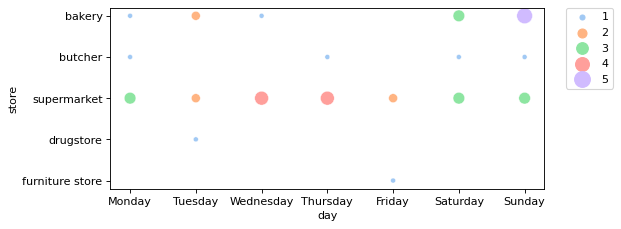

In [ ]:
df_nunique = df.groupby(['day', 'store_type'])['order_ID'].nunique()
df_nunique = pd.DataFrame (df_nunique)
df_nunique = df_nunique.reset_index()
df_nunique = df_nunique.loc[~(df_nunique==0).any(axis=1)]


#order x and y axis chronologically
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_nunique['day'] = pd.Categorical(df_nunique['day'], order)
df_nunique.sort_values(by=['day'], inplace=True)


# select the x and y features
x = df_nunique['day']# select the x feature
y = df_nunique['store_type']# select the y feature

# select the feature that decides the colors
colors = df_nunique['order_ID'] # select the color column

# select the feature that will decide the size of the circle (and divide the value by 1000 for reshaping in the plot)
size = df_nunique['order_ID'] # select the column for the size and divide it by 1000 (/ 1000)

# fit the points with the scatter function
figure(figsize=(7, 3), dpi=80)
sns.scatterplot(x=x, y=y, palette="pastel", hue=colors, size=size, sizes=(20,200))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#repeat ChiSq value
current_corr = round(ChiSqResult[1], 2)

# give the graph a title and labels
plt.xlabel("day")
plt.ylabel('store')
# plt.title(f"The correlation between day & store type (r={current_corr})")

# call the graph (show function)
plt.grid(False)
plt.show()

In [ ]:
df_orders['day'] = pd.Categorical(df_orders['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

df_orders=df_orders.sort_values(by='day')
# Cross tabulation between DAY and STORE TYPE
CrosstabResult=pd.crosstab(index=df_orders['store_type'],columns=df_orders['day'])
CrosstabResult

day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
store_type,,,,,,,
bakery,1,2,1,0,0,3,5
butcher,1,0,0,1,0,1,1
drugstore,0,1,0,0,0,0,0
furniture store,0,0,0,0,1,0,0
supermarket,4,2,4,4,2,3,3


In [ ]:
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.20212640487695543


In [ ]:
df_orders = df[['order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

# aggregate afternoon and evening
df_orders['day'] = df_orders['day'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'weekday')
df_orders['day'] = df_orders['day'].replace(['Saturday', 'Sunday'], 'weekend')

# aggregate afternoon and evening
df_orders['store_type'] = df_orders['store_type'].replace(['drugstore', 'furniture store'], 'other')
df_orders.drop(df_orders[df_orders['store_type']== 'other'].index, inplace = True)
# df_orders['store_type'] = df_orders['store_type'].replace(['bakery', 'butcher'], 'bakery/butcher')

In [ ]:
# Cross tabulation between DAY and STORE NAME
CrosstabResult=pd.crosstab(index=df_orders['store_type'],columns=df_orders['day'])
display(CrosstabResult)

# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', round(ChiSqResult[1], 2))

day,weekday,weekend
store_type,,
bakery,4,8
butcher,2,2
supermarket,16,6


The P-Value of the ChiSq Test is: 0.08


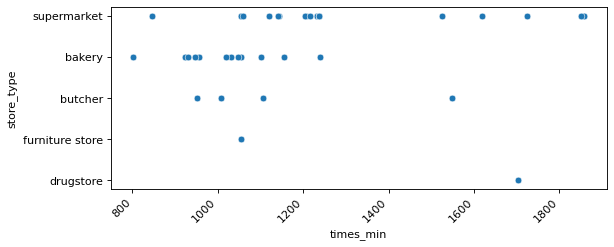

In [ ]:
from scipy.stats import f_oneway

figure(figsize=(8, 3), dpi=80)
plt.xticks(rotation=45, ha='right')

sns.scatterplot(data=df_orders, x='times_min', y='store_type')

# Finds out the Prices data for each FuelType as a list
CategoryGroupLists=df_orders.groupby('store_type')['times_min'].apply(list)
# Performing the ANOVA test
# We reject the Assumption(H0) only when P-Value < 0.05
AnovaResults = f_oneway(*CategoryGroupLists)
# get the correlation between both variables
current_corr = round(AnovaResults[1], 2)

# give the graph a title and labels
# plt.title(f"The Anova P-value between store type & time = (r={current_corr})")

# call the graph (show function)
plt.grid(False)
plt.show()

In [ ]:
df_orders = df[['order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

def categorize(row):  
    if row['times_min'] <= 1230:
        return 'morning'
    elif row['times_min'] > 1230:
        return 'afternoon'
    
    
df_orders['time'] = df.apply(lambda row: categorize(row), axis=1)

# aggregate afternoon and evening
df_orders['store_type'] = df_orders['store_type'].replace(['drugstore', 'furniture store'], 'other')
df_orders.drop(df_orders[df_orders['store_type']== 'other'].index, inplace = True)
# df_orders['store_type'] = df_orders['store_type'].replace(['bakery', 'butcher'], 'bakery/butcher')

In [ ]:
# Cross tabulation between DAY and STORE NAME
CrosstabResult=pd.crosstab(index=df_orders['store_type'],columns=df_orders['time'])
display(CrosstabResult)

# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', round(ChiSqResult[1], 2))

time,afternoon,morning
store_type,,
bakery,1,11
butcher,1,3
supermarket,12,10


The P-Value of the ChiSq Test is: 0.02


Let's get more specific:

### check correlation per store NAME

In [ ]:
df_orders = df[['order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

In [ ]:
# Cross tabulation between DAY and STORE NAME
CrosstabResult=pd.crosstab(index=df_orders['store_name'],columns=df_orders['day'])
CrosstabResult

day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
store_name,,,,,,,
Albert Heijn,4,0,4,2,1,0,1
Brabo,0,0,0,1,0,0,0
Carrefour,0,0,0,0,0,1,0
Delhaize,0,0,0,0,1,0,2
Ikea,0,0,0,0,1,0,0
Kruidvat,0,1,0,0,0,0,0
Okay,0,2,0,2,0,2,0
Sys,1,2,1,0,0,3,5
Versavel Poelman,1,0,0,0,0,1,1


In [ ]:
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.03865973858951409


In [ ]:
# aggregate afternoon and evening
df_orders['day'] = df_orders['day'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'weekday')
df_orders['day'] = df_orders['day'].replace(['Saturday', 'Sunday'], 'weekend')

In [ ]:
# Cross tabulation between DAY and STORE NAME
CrosstabResult=pd.crosstab(index=df_orders['store_name'],columns=df_orders['day'])
CrosstabResult

day,weekday,weekend
store_name,,
Albert Heijn,11,1
Brabo,1,0
Carrefour,0,1
Delhaize,1,2
Ikea,1,0
Kruidvat,1,0
Okay,4,2
Sys,4,8
Versavel Poelman,1,2


In [ ]:
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.08285792764551078


This p-value is low enough to be a significant correlation!
> e.g.: if it's Wednesday, they will probably go shopping at Albert Heijn

### Visualize stores per day (ALL)

In [ ]:
df_nunique = df.groupby(['day', 'store_name'])['order_ID'].nunique()
df_nunique = pd.DataFrame (df_nunique)
df_nunique = df_nunique.reset_index()
df_nunique = df_nunique.loc[~(df_nunique==0).any(axis=1)]

#order x and y axis chronologically
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_nunique['day'] = pd.Categorical(df_nunique['day'], order)
df_nunique.sort_values(by=['day'], inplace=True)


# select the x and y features
x = df_nunique['day']# select the x feature
y = df_nunique['store_name']# select the y feature

# select the feature that decides the colors
colors = df_nunique['order_ID'] # select the color column

# select the feature that will decide the size of the circle (and divide the value by 1000 for reshaping in the plot)
size = df_nunique['order_ID'] # select the column for the size and divide it by 1000 (/ 1000)

# fit the points with the scatter function
figure(figsize=(7, 3), dpi=80)
sns.scatterplot(x=x, y=y, palette="pastel", hue=colors, size=size, sizes=(20,200))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#repeat ChiSq value
current_corr = round(ChiSqResult[1], 2)

# give the graph a title and labels
plt.xlabel("day")
plt.ylabel('time')
plt.title(f"The correlation between day & store name (r={current_corr})")

# call the graph (show function)
plt.grid(False)
plt.show()

### New Dataframes per day

In [ ]:
# Select only one day
Monday = 'Monday'
Tuesday = 'Tuesday'
Wednesday = 'Wednesday'
Thursday = 'Thursday'
Friday = 'Friday'
Saturday = 'Saturday'
Sunday = 'Sunday'

# select only these data for the df
df_Monday = df[df['day'] == 'Monday']
df_Tuesday = df[df['day'] == 'Tuesday']
df_Wednesday = df[df['day'] == 'Wednesday']
df_Thursday = df[df['day'] == 'Thursday']
df_Friday = df[df['day'] == 'Friday']
df_Saturday = df[df['day'] == 'Saturday']
df_Sunday = df[df['day'] == 'Sunday']

In [ ]:
df_Mo = df_Monday.groupby(['store_name', 'store_type'])['order_ID'].nunique()
df_Mo = pd.DataFrame (df_Mo)
df_Mo = df_Mo.reset_index()
df_Mo = df_Mo.loc[~(df_Mo==0).any(axis=1)]
df_Mo = df_Mo.rename(columns={"order_ID": "weight"})

df_Tu = df_Tuesday.groupby(['store_name', 'store_type'])['order_ID'].nunique()
df_Tu = pd.DataFrame (df_Tu)
df_Tu = df_Tu.reset_index()
df_Tu = df_Tu.loc[~(df_Tu==0).any(axis=1)]
df_Tu = df_Tu.rename(columns={"order_ID": "weight"})

df_We = df_Wednesday.groupby(['store_name', 'store_type'])['order_ID'].nunique()
df_We = pd.DataFrame (df_We)
df_We = df_We.reset_index()
df_We = df_We.loc[~(df_We==0).any(axis=1)]
df_We = df_We.rename(columns={"order_ID": "weight"})

df_Th = df_Thursday.groupby(['store_name', 'store_type'])['order_ID'].nunique()
df_Th = pd.DataFrame (df_Th)
df_Th = df_Th.reset_index()
df_Th = df_Th.loc[~(df_Th==0).any(axis=1)]
df_Th = df_Th.rename(columns={"order_ID": "weight"})

df_Fr = df_Friday.groupby(['store_name', 'store_type'])['order_ID'].nunique()
df_Fr = pd.DataFrame (df_Fr)
df_Fr = df_Fr.reset_index()
df_Fr = df_Fr.loc[~(df_Fr==0).any(axis=1)]
df_Fr = df_Fr.rename(columns={"order_ID": "weight"})

df_Sa = df_Saturday.groupby(['store_name', 'store_type'])['order_ID'].nunique()
df_Sa = pd.DataFrame (df_Sa)
df_Sa = df_Sa.reset_index()
df_Sa = df_Sa.loc[~(df_Sa==0).any(axis=1)]
df_Sa = df_Sa.rename(columns={"order_ID": "weight"})

df_Su = df_Sunday.groupby(['store_name', 'store_type'])['order_ID'].nunique()
df_Su = pd.DataFrame (df_Su)
df_Su = df_Su.reset_index()
df_Su = df_Su.loc[~(df_Su==0).any(axis=1)]
df_Su = df_Su.rename(columns={"order_ID": "weight"})

In [ ]:
df_Mo.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_Mo.csv", index = None, header=True)
df_Tu.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_Tu.csv", index = None, header=True)
df_We.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_We.csv", index = None, header=True)
df_Th.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_Th.csv", index = None, header=True)
df_Fr.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_Fr.csv", index = None, header=True)
df_Sa.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_Sa.csv", index = None, header=True)
df_Su.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_Su.csv", index = None, header=True)

### CONCLUSION

We now have our first TWO givens:
> 1. It is <b>day X</b>
2. The HH will shop at <b>store name X</b>

## 2.2.3. At what time?

### Load and view data 

In [ ]:
df = pd.read_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2.csv")

# del df["HH"]
# df.describe(include='all')

In [ ]:
# use the corr function to display the correlation between all the features
data_corr = df.corr()
# data_corr

In [ ]:
# df_count = df[['order_ID','store_name', 'day']]
# df_count = df_count.drop_duplicates()
# df_count = df_count.drop(columns=['order_ID'])
# df_count.head()

### 2.2.3.1 DAY vs TIME (all orders)

In [ ]:
df_orders = df[['order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

In [ ]:
# Cross tabulation between DAY and TIME
CrosstabResult=pd.crosstab(index=df_orders['time'],columns=df_orders['day'])
display(CrosstabResult)


# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
time,,,,,,,
afternoon,1,0,1,0,2,1,0
evening,0,1,1,0,1,0,0
morning,1,2,5,9,1,2,2
noon,1,3,0,0,1,2,3


The P-Value of the ChiSq Test is: 0.1226046357444237


#### Let's try check continuous time vs day

In [ ]:
# f_oneway() function takes the group data as input and 
# returns F-statistic and P-value
from scipy.stats import f_oneway
 
# Assumption(H0) is that day and times are NOT correlated
 
# Finds out the Prices data for each FuelType as a list
CategoryGroupLists=df_orders.groupby('day')['times_min'].apply(list)
 
# Performing the ANOVA test
# We reject the Assumption(H0) only when P-Value < 0.05
AnovaResults = f_oneway(*CategoryGroupLists)
print('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  0.07923696121350002


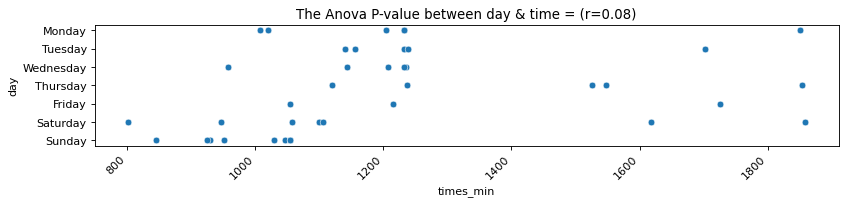

In [ ]:
df_orders['day'] = pd.Categorical(df_orders['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

df_orders=df_orders.sort_values(by='day')

figure(figsize=(12, 2), dpi=80)
plt.xticks(rotation=45, ha='right')

sns.scatterplot(data=df_orders, x='times_min', y='day')

# get the Pearson correlation between both variables
current_corr = round(AnovaResults[1], 2)

# give the graph a title and labels
plt.title(f"The Anova P-value between day & time = (r={current_corr})")

# call the graph (show function)
plt.grid(False)
plt.show()

#### Let's try afternoon and evening as one group

In [ ]:
# aggregate afternoon and evening
# df_orders['time'] = df_orders['time'].replace(['afternoon', 'evening'], 'afternoon')

In [ ]:
df = pd.read_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2.csv")
df_orders = df[['order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

In [ ]:
def categorize(row):  
    if row['times_min'] <= 1230:
        return 'morning'
    elif row['times_min'] > 1230:
        return 'afternoon'
    
    
df_orders['time'] = df.apply(lambda row: categorize(row), axis=1)

In [ ]:
df_orders['day'] = pd.Categorical(df_orders['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

df_orders=df_orders.sort_values(by='day')
# Cross tabulation between DAY and TIME
CrosstabResult=pd.crosstab(index=df_orders['time'],columns=df_orders['day'])
display(CrosstabResult)

# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
time,,,,,,,
afternoon,3,3,2,4,1,2,0
morning,3,2,3,1,2,5,9


The P-Value of the ChiSq Test is: 0.08816081915644006


#### Let's try grouping weekdays and weekends

In [ ]:
# aggregate afternoon and evening
df_orders['day'] = df_orders['day'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'weekday')
df_orders['day'] = df_orders['day'].replace(['Saturday', 'Sunday'], 'weekend')

In [ ]:
# Cross tabulation between DAY and TIME
CrosstabResult=pd.crosstab(index=df_orders['time'],columns=df_orders['day'])
display(CrosstabResult)

# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

day,weekday,weekend
time,,
afternoon,13,2
morning,11,14


The P-Value of the ChiSq Test is: 0.019630657257290702


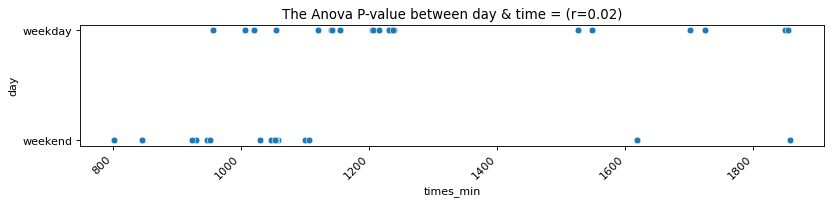

In [ ]:
figure(figsize=(12, 2), dpi=80)
plt.xticks(rotation=45, ha='right')

sns.scatterplot(data=df_orders, x='times_min', y='day')

# Finds out the Prices data for each FuelType as a list
CategoryGroupLists=df_orders.groupby('day')['times_min'].apply(list)
# Performing the ANOVA test
# We reject the Assumption(H0) only when P-Value < 0.05
AnovaResults = f_oneway(*CategoryGroupLists)
# get the correlation between both variables
current_corr = round(AnovaResults[1], 2)

# give the graph a title and labels
plt.title(f"The Anova P-value between day & time = (r={current_corr})")

# call the graph (show function)
plt.grid(False)
plt.show()

### Load and view data 

In [ ]:
df = pd.read_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2.csv")

# del df["HH"]
# df.describe(include='all')

In [ ]:
# use the corr function to display the correlation between all the features
data_corr = df.corr()
# data_corr

In [ ]:
# df_count = df[['order_ID','store_name', 'day']]
# df_count = df_count.drop_duplicates()
# df_count = df_count.drop(columns=['order_ID'])
# df_count.head()

### 2.2.3.1 DAY vs TIME (all orders)

In [ ]:
df_orders = df[['order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

In [ ]:
# Cross tabulation between DAY and TIME
CrosstabResult=pd.crosstab(index=df_orders['time'],columns=df_orders['day'])
display(CrosstabResult)


# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
time,,,,,,,
afternoon,1,0,1,0,2,1,0
evening,0,1,1,0,1,0,0
morning,1,2,5,9,1,2,2
noon,1,3,0,0,1,2,3


The P-Value of the ChiSq Test is: 0.1226046357444237


#### Let's try check continuous time vs day

In [ ]:
# f_oneway() function takes the group data as input and 
# returns F-statistic and P-value
from scipy.stats import f_oneway
 
# Assumption(H0) is that day and times are NOT correlated
 
# Finds out the Prices data for each FuelType as a list
CategoryGroupLists=df_orders.groupby('day')['times_min'].apply(list)
 
# Performing the ANOVA test
# We reject the Assumption(H0) only when P-Value < 0.05
AnovaResults = f_oneway(*CategoryGroupLists)
print('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  0.07923696121350002


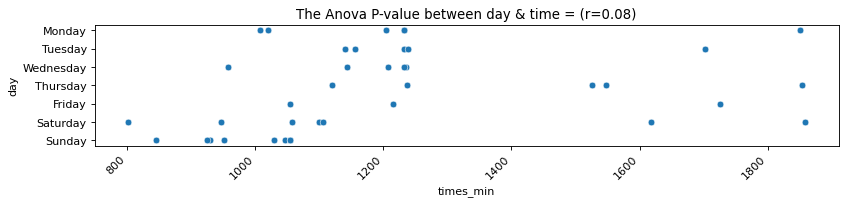

In [ ]:
df_orders['day'] = pd.Categorical(df_orders['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

df_orders=df_orders.sort_values(by='day')

figure(figsize=(12, 2), dpi=80)
plt.xticks(rotation=45, ha='right')

sns.scatterplot(data=df_orders, x='times_min', y='day')

# get the Pearson correlation between both variables
current_corr = round(AnovaResults[1], 2)

# give the graph a title and labels
plt.title(f"The Anova P-value between day & time = (r={current_corr})")

# call the graph (show function)
plt.grid(False)
plt.show()

#### Let's try afternoon and evening as one group

In [ ]:
# aggregate afternoon and evening
# df_orders['time'] = df_orders['time'].replace(['afternoon', 'evening'], 'afternoon')

In [ ]:
df = pd.read_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2.csv")
df_orders = df[['order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

In [ ]:
def categorize(row):  
    if row['times_min'] <= 1230:
        return 'morning'
    elif row['times_min'] > 1230:
        return 'afternoon'
    
    
df_orders['time'] = df.apply(lambda row: categorize(row), axis=1)

In [ ]:
df_orders['day'] = pd.Categorical(df_orders['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

df_orders=df_orders.sort_values(by='day')
# Cross tabulation between DAY and TIME
CrosstabResult=pd.crosstab(index=df_orders['time'],columns=df_orders['day'])
display(CrosstabResult)

# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
time,,,,,,,
afternoon,3,3,2,4,1,2,0
morning,3,2,3,1,2,5,9


The P-Value of the ChiSq Test is: 0.08816081915644006


#### Let's try grouping weekdays and weekends

In [ ]:
# aggregate afternoon and evening
df_orders['day'] = df_orders['day'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'weekday')
df_orders['day'] = df_orders['day'].replace(['Saturday', 'Sunday'], 'weekend')

In [ ]:
# Cross tabulation between DAY and TIME
CrosstabResult=pd.crosstab(index=df_orders['time'],columns=df_orders['day'])
display(CrosstabResult)

# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

day,weekday,weekend
time,,
afternoon,13,2
morning,11,14


The P-Value of the ChiSq Test is: 0.019630657257290702


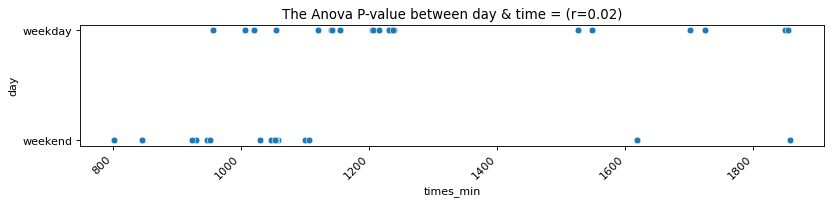

In [ ]:
figure(figsize=(12, 2), dpi=80)
plt.xticks(rotation=45, ha='right')

sns.scatterplot(data=df_orders, x='times_min', y='day')

# Finds out the Prices data for each FuelType as a list
CategoryGroupLists=df_orders.groupby('day')['times_min'].apply(list)
# Performing the ANOVA test
# We reject the Assumption(H0) only when P-Value < 0.05
AnovaResults = f_oneway(*CategoryGroupLists)
# get the correlation between both variables
current_corr = round(AnovaResults[1], 2)

# give the graph a title and labels
plt.title(f"The Anova P-value between day & time = (r={current_corr})")

# call the graph (show function)
plt.grid(False)
plt.show()

### 2.2.3.2 DAY VS TIME @ SPECIFIED STORE

In [ ]:
df = pd.read_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2.csv")

df_orders = df[['order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

#### Now that we know which store, we select the correct store

In [ ]:
# to select only one
store1 = 'Albert Heijn'
store2 = 'Sys'
store3 = 'Okay'
store4 = 'Delhaize'
store5 = 'Versavel Poelman'
store6 = 'Kruidvat'
store7 = 'Brabo'
store8 = 'Ikea'
store9 = 'Carrefour'

# select only these data for the df
df_store1 = df_orders[df_orders['store_name'] == store1]
df_store2 = df_orders[df_orders['store_name'] == store2]
df_store3 = df_orders[df_orders['store_name'] == store3]
df_store4 = df_orders[df_orders['store_name'] == store4]
df_store5 = df_orders[df_orders['store_name'] == store5]
df_store6 = df_orders[df_orders['store_name'] == store6]
df_store7 = df_orders[df_orders['store_name'] == store7]
df_store8 = df_orders[df_orders['store_name'] == store8]
df_store9 = df_orders[df_orders['store_name'] == store9]

In [ ]:
# Cross tabulation between DAY and TIME
CrosstabResult1=pd.crosstab(index=df_store1['time'],columns=df_store1['day'])
CrosstabResult2=pd.crosstab(index=df_store2['time'],columns=df_store2['day'])
CrosstabResult3=pd.crosstab(index=df_store3['time'],columns=df_store3['day'])
CrosstabResult4=pd.crosstab(index=df_store4['time'],columns=df_store4['day'])
CrosstabResult5=pd.crosstab(index=df_store5['time'],columns=df_store5['day'])
CrosstabResult6=pd.crosstab(index=df_store6['time'],columns=df_store6['day'])
CrosstabResult7=pd.crosstab(index=df_store7['time'],columns=df_store7['day'])
CrosstabResult8=pd.crosstab(index=df_store8['time'],columns=df_store8['day'])
CrosstabResult9=pd.crosstab(index=df_store9['time'],columns=df_store9['day'])
CrosstabResult3

day,weekday,weekend
time,,
afternoon,3,1
morning,1,1


In [ ]:
# Performing Chi-sq test
ChiSqResult1 = chi2_contingency(CrosstabResult1)
ChiSqResult2 = chi2_contingency(CrosstabResult2)
ChiSqResult3 = chi2_contingency(CrosstabResult3)
ChiSqResult4 = chi2_contingency(CrosstabResult4)
ChiSqResult5 = chi2_contingency(CrosstabResult5)
ChiSqResult6 = chi2_contingency(CrosstabResult6)
ChiSqResult7 = chi2_contingency(CrosstabResult7)
ChiSqResult8 = chi2_contingency(CrosstabResult8)
ChiSqResult9 = chi2_contingency(CrosstabResult9)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test 1 is:', ChiSqResult1[1])
print('The P-Value of the ChiSq Test 2 is:', ChiSqResult2[1])
print('The P-Value of the ChiSq Test 3 is:', ChiSqResult3[1])
print('The P-Value of the ChiSq Test 4 is:', ChiSqResult4[1])
print('The P-Value of the ChiSq Test 5 is:', ChiSqResult5[1])
print('The P-Value of the ChiSq Test 6 is:', ChiSqResult6[1])
print('The P-Value of the ChiSq Test 7 is:', ChiSqResult7[1])
print('The P-Value of the ChiSq Test 8 is:', ChiSqResult8[1])
print('The P-Value of the ChiSq Test 9 is:', ChiSqResult9[1])

The P-Value of the ChiSq Test 1 is: 1.0
The P-Value of the ChiSq Test 2 is: 0.71192315069219
The P-Value of the ChiSq Test 3 is: 1.0
The P-Value of the ChiSq Test 4 is: 0.6650055421020291
The P-Value of the ChiSq Test 5 is: 1.0
The P-Value of the ChiSq Test 6 is: 1.0
The P-Value of the ChiSq Test 7 is: 1.0
The P-Value of the ChiSq Test 8 is: 1.0
The P-Value of the ChiSq Test 9 is: 1.0


#### Let's try store type

In [ ]:
# to select only one
storet1 = 'supermarket'
storet2 = 'butcher'
storet3 = 'bakery'
storet4 = 'drugstore'
storet5 = 'furniture store'

# select only these data for the df
df_storet1 = df_orders[df_orders['store_type'] == storet1]
df_storet2 = df_orders[df_orders['store_type'] == storet2]
df_storet3 = df_orders[df_orders['store_type'] == storet3]
df_storet4 = df_orders[df_orders['store_type'] == storet4]
df_storet5 = df_orders[df_orders['store_type'] == storet5]

# Cross tabulation between DAY and TIME
CrosstabResult1=pd.crosstab(index=df_storet1['time'],columns=df_storet1['day'])
CrosstabResult2=pd.crosstab(index=df_storet2['time'],columns=df_storet2['day'])
CrosstabResult3=pd.crosstab(index=df_storet3['time'],columns=df_storet3['day'])
CrosstabResult4=pd.crosstab(index=df_storet4['time'],columns=df_storet4['day'])
CrosstabResult5=pd.crosstab(index=df_storet5['time'],columns=df_storet5['day'])
CrosstabResult1

# Performing Chi-sq test
ChiSqResult1 = chi2_contingency(CrosstabResult1)
ChiSqResult2 = chi2_contingency(CrosstabResult2)
ChiSqResult3 = chi2_contingency(CrosstabResult3)
ChiSqResult4 = chi2_contingency(CrosstabResult4)
ChiSqResult5 = chi2_contingency(CrosstabResult5)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test 1 is:', ChiSqResult1[1])
print('The P-Value of the ChiSq Test 2 is:', ChiSqResult2[1])
print('The P-Value of the ChiSq Test 3 is:', ChiSqResult3[1])
print('The P-Value of the ChiSq Test 4 is:', ChiSqResult4[1])
print('The P-Value of the ChiSq Test 5 is:', ChiSqResult5[1])

WHAT IF WE AGGREGATE BOTH WEEK/WEEKEND & 3 TIMES

In [ ]:
# df = pd.read_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2.csv")

# df_orders = df[['order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
# df_orders = df_orders.drop_duplicates()

In [ ]:
df_storet1 = df_orders[df_orders['store_type'] == storet1]
df_storet1 = df_orders[df_orders['store_name'] == storet2]

In [ ]:
# Cross tabulation between DAY and TIME
CrosstabResult=pd.crosstab(index=df_storet1['time'],columns=df_storet1['day'])
CrosstabResult

day,weekday,weekend
time,,
afternoon,4,2
morning,3,4
noon,9,0


In [ ]:
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.03624476516103243


#### Significant for store type @ week/weekend @3cat
> perhaps not very useful?

### 2.2.3.3. New Dataframes per day

In [ ]:
# aggregate afternoon and evening
df_orders['time'] = df_orders['time'].replace(['afternoon', 'evening'], 'afternoon')

In [ ]:
# Select only one day
Monday = 'Monday'
Tuesday = 'Tuesday'
Wednesday = 'Wednesday'
Thursday = 'Thursday'
Friday = 'Friday'
Saturday = 'Saturday'
Sunday = 'Sunday'

# select only these data for the df
df_Monday = df_orders[df_orders['day'] == 'Monday']
df_Tuesday = df_orders[df_orders['day'] == 'Tuesday']
df_Wednesday = df_orders[df_orders['day'] == 'Wednesday']
df_Thursday = df_orders[df_orders['day'] == 'Thursday']
df_Friday = df_orders[df_orders['day'] == 'Friday']
df_Saturday = df_orders[df_orders['day'] == 'Saturday']
df_Sunday = df_orders[df_orders['day'] == 'Sunday']

In [ ]:
df_Sunday

,order_ID,store_name,storename_num,store_type,storetype_num,day,day_num,time,time_num,timestamp,times,dates,times_min,dates_days,order_amount,order_price


In [ ]:
df_Mo = df_Monday.groupby(['time'])['order_ID'].nunique()
df_Mo = pd.DataFrame (df_Mo)
df_Mo = df_Mo.reset_index()
df_Mo = df_Mo.loc[~(df_Mo==0).any(axis=1)]
df_Mo = df_Mo.rename(columns={"order_ID": "weight"})

df_Tu = df_Tuesday.groupby(['time'])['order_ID'].nunique()
df_Tu = pd.DataFrame (df_Tu)
df_Tu = df_Tu.reset_index()
df_Tu = df_Tu.loc[~(df_Tu==0).any(axis=1)]
df_Tu = df_Tu.rename(columns={"order_ID": "weight"})

df_We = df_Wednesday.groupby(['time'])['order_ID'].nunique()
df_We = pd.DataFrame (df_We)
df_We = df_We.reset_index()
df_We = df_We.loc[~(df_We==0).any(axis=1)]
df_We = df_We.rename(columns={"order_ID": "weight"})

df_Th = df_Thursday.groupby(['time'])['order_ID'].nunique()
df_Th = pd.DataFrame (df_Th)
df_Th = df_Th.reset_index()
df_Th = df_Th.loc[~(df_Th==0).any(axis=1)]
df_Th = df_Th.rename(columns={"order_ID": "weight"})

df_Fr = df_Friday.groupby(['time'])['order_ID'].nunique()
df_Fr = pd.DataFrame (df_Fr)
df_Fr = df_Fr.reset_index()
df_Fr = df_Fr.loc[~(df_Fr==0).any(axis=1)]
df_Fr = df_Fr.rename(columns={"order_ID": "weight"})

df_Sa = df_Saturday.groupby(['time'])['order_ID'].nunique()
df_Sa = pd.DataFrame (df_Sa)
df_Sa = df_Sa.reset_index()
df_Sa = df_Sa.loc[~(df_Sa==0).any(axis=1)]
df_Sa = df_Sa.rename(columns={"order_ID": "weight"})

df_Su = df_Sunday.groupby(['time'])['order_ID'].nunique()
df_Su = pd.DataFrame (df_Su)
df_Su = df_Su.reset_index()
df_Su = df_Su.loc[~(df_Su==0).any(axis=1)]
df_Su = df_Su.rename(columns={"order_ID": "weight"})

In [ ]:
df_Mo.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_MoTime.csv", index = None, header=True)
df_Tu.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_TuTime.csv", index = None, header=True)
df_We.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_WeTime.csv", index = None, header=True)
df_Th.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_ThTime.csv", index = None, header=True)
df_Fr.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_FrTime.csv", index = None, header=True)
df_Sa.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_SaTime.csv", index = None, header=True)
df_Su.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_SuTime.csv", index = None, header=True)

### REVISING THE FLOW -- TIME AFTER STORE NAME DEFINED (+ day)

### 2.2.3.4. STORE NAME vs TIME (all orders)

In [ ]:
df_orders = df[['order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

In [ ]:
# aggregate afternoon and evening
df_orders['time'] = df_orders['time'].replace(['afternoon', 'evening'], 'afternoon')

In [ ]:
# Cross tabulation between DAY and TIME
CrosstabResult=pd.crosstab(index=df_orders['time'],columns=df_orders['store_name'])
print(CrosstabResult)


# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

store_name  Albert Heijn  Brabo  Carrefour  Delhaize  Ikea  Kruidvat  Okay  \
time                                                                         
afternoon              1      1          1         1     0         1     3   
morning                3      0          0         2     1         0     2   
noon                   8      0          0         0     0         0     1   

store_name  Sys  Versavel Poelman  
time                               
afternoon     0                 0  
morning      11                 3  
noon          1                 0  
The P-Value of the ChiSq Test is: 0.0017692256955682132


#### For specified days

In [ ]:
# Select only one day
Monday = 'Monday'
Tuesday = 'Tuesday'
Wednesday = 'Wednesday'
Thursday = 'Thursday'
Friday = 'Friday'
Saturday = 'Saturday'
Sunday = 'Sunday'

# select only these data for the df
df_Monday = df_orders[df_orders['day'] == 'Monday']
df_Tuesday = df_orders[df_orders['day'] == 'Tuesday']
df_Wednesday = df_orders[df_orders['day'] == 'Wednesday']
df_Thursday = df_orders[df_orders['day'] == 'Thursday']
df_Friday = df_orders[df_orders['day'] == 'Friday']
df_Saturday = df_orders[df_orders['day'] == 'Saturday']
df_Sunday = df_orders[df_orders['day'] == 'Sunday']

In [ ]:
CrosstabResult_Mo=pd.crosstab(index=df_Monday['store_name'],columns=df_Monday['time'])
CrosstabResult_Tu=pd.crosstab(index=df_Tuesday['store_name'],columns=df_Tuesday['time'])
CrosstabResult_We=pd.crosstab(index=df_Wednesday['store_name'],columns=df_Wednesday['time'])
CrosstabResult_Th=pd.crosstab(index=df_Thursday['store_name'],columns=df_Thursday['time'])
CrosstabResult_Fr=pd.crosstab(index=df_Friday['store_name'],columns=df_Friday['time'])
CrosstabResult_Sa=pd.crosstab(index=df_Saturday['store_name'],columns=df_Saturday['time'])
CrosstabResult_Su=pd.crosstab(index=df_Sunday['store_name'],columns=df_Sunday['time'])
CrosstabResult_Th

time,afternoon,morning,noon
store_name,,,
Albert Heijn,0,1,1
Brabo,1,0,0
Okay,2,0,0


In [ ]:
# Performing Chi-sq test
ChiSqResult_Mo = chi2_contingency(CrosstabResult_Mo)
ChiSqResult_Tu = chi2_contingency(CrosstabResult_Tu)
ChiSqResult_We = chi2_contingency(CrosstabResult_We)
ChiSqResult_Th = chi2_contingency(CrosstabResult_Th)
ChiSqResult_Fr = chi2_contingency(CrosstabResult_Fr)
ChiSqResult_Sa = chi2_contingency(CrosstabResult_Sa)
ChiSqResult_Su = chi2_contingency(CrosstabResult_Su)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test for Monday is:', ChiSqResult_Mo[1])
print('The P-Value of the ChiSq Test for Tuesday is:', ChiSqResult_Tu[1])
print('The P-Value of the ChiSq Test for Wednesday is:', ChiSqResult_We[1])
print('The P-Value of the ChiSq Test for Thursday is:', ChiSqResult_Th[1])
print('The P-Value of the ChiSq Test for Friday is:', ChiSqResult_Fr[1])
print('The P-Value of the ChiSq Test for Saturday is:', ChiSqResult_Sa[1])
print('The P-Value of the ChiSq Test for Sunday is:', ChiSqResult_Su[1])

The P-Value of the ChiSq Test for Monday is: 0.1991482734714558
The P-Value of the ChiSq Test for Tuesday is: 0.2872974951836458
The P-Value of the ChiSq Test for Wednesday is: 0.8194769767775212
The P-Value of the ChiSq Test for Thursday is: 0.2872974951836458
The P-Value of the ChiSq Test for Friday is: 0.19914827347145564
The P-Value of the ChiSq Test for Saturday is: 0.2078735268092497
The P-Value of the ChiSq Test for Sunday is: 1.0


### 2.2.3.2 DAY VS TIME @ SPECIFIED STORE

In [ ]:
df = pd.read_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2.csv")

df_orders = df[['order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

#### Now that we know which store, we select the correct store

In [ ]:
# to select only one
store1 = 'Albert Heijn'
store2 = 'Sys'
store3 = 'Okay'
store4 = 'Delhaize'
store5 = 'Versavel Poelman'
store6 = 'Kruidvat'
store7 = 'Brabo'
store8 = 'Ikea'
store9 = 'Carrefour'

# select only these data for the df
df_store1 = df_orders[df_orders['store_name'] == store1]
df_store2 = df_orders[df_orders['store_name'] == store2]
df_store3 = df_orders[df_orders['store_name'] == store3]
df_store4 = df_orders[df_orders['store_name'] == store4]
df_store5 = df_orders[df_orders['store_name'] == store5]
df_store6 = df_orders[df_orders['store_name'] == store6]
df_store7 = df_orders[df_orders['store_name'] == store7]
df_store8 = df_orders[df_orders['store_name'] == store8]
df_store9 = df_orders[df_orders['store_name'] == store9]

In [ ]:
# Cross tabulation between DAY and TIME
CrosstabResult1=pd.crosstab(index=df_store1['time'],columns=df_store1['day'])
CrosstabResult2=pd.crosstab(index=df_store2['time'],columns=df_store2['day'])
CrosstabResult3=pd.crosstab(index=df_store3['time'],columns=df_store3['day'])
CrosstabResult4=pd.crosstab(index=df_store4['time'],columns=df_store4['day'])
CrosstabResult5=pd.crosstab(index=df_store5['time'],columns=df_store5['day'])
CrosstabResult6=pd.crosstab(index=df_store6['time'],columns=df_store6['day'])
CrosstabResult7=pd.crosstab(index=df_store7['time'],columns=df_store7['day'])
CrosstabResult8=pd.crosstab(index=df_store8['time'],columns=df_store8['day'])
CrosstabResult9=pd.crosstab(index=df_store9['time'],columns=df_store9['day'])
CrosstabResult3

day,weekday,weekend
time,,
afternoon,3,1
morning,1,1


In [ ]:
# Performing Chi-sq test
ChiSqResult1 = chi2_contingency(CrosstabResult1)
ChiSqResult2 = chi2_contingency(CrosstabResult2)
ChiSqResult3 = chi2_contingency(CrosstabResult3)
ChiSqResult4 = chi2_contingency(CrosstabResult4)
ChiSqResult5 = chi2_contingency(CrosstabResult5)
ChiSqResult6 = chi2_contingency(CrosstabResult6)
ChiSqResult7 = chi2_contingency(CrosstabResult7)
ChiSqResult8 = chi2_contingency(CrosstabResult8)
ChiSqResult9 = chi2_contingency(CrosstabResult9)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test 1 is:', ChiSqResult1[1])
print('The P-Value of the ChiSq Test 2 is:', ChiSqResult2[1])
print('The P-Value of the ChiSq Test 3 is:', ChiSqResult3[1])
print('The P-Value of the ChiSq Test 4 is:', ChiSqResult4[1])
print('The P-Value of the ChiSq Test 5 is:', ChiSqResult5[1])
print('The P-Value of the ChiSq Test 6 is:', ChiSqResult6[1])
print('The P-Value of the ChiSq Test 7 is:', ChiSqResult7[1])
print('The P-Value of the ChiSq Test 8 is:', ChiSqResult8[1])
print('The P-Value of the ChiSq Test 9 is:', ChiSqResult9[1])

The P-Value of the ChiSq Test 1 is: 1.0
The P-Value of the ChiSq Test 2 is: 0.71192315069219
The P-Value of the ChiSq Test 3 is: 1.0
The P-Value of the ChiSq Test 4 is: 0.6650055421020291
The P-Value of the ChiSq Test 5 is: 1.0
The P-Value of the ChiSq Test 6 is: 1.0
The P-Value of the ChiSq Test 7 is: 1.0
The P-Value of the ChiSq Test 8 is: 1.0
The P-Value of the ChiSq Test 9 is: 1.0


#### Let's try store type

In [ ]:
# to select only one
storet1 = 'supermarket'
storet2 = 'butcher'
storet3 = 'bakery'
storet4 = 'drugstore'
storet5 = 'furniture store'

# select only these data for the df
df_storet1 = df_orders[df_orders['store_type'] == storet1]
df_storet2 = df_orders[df_orders['store_type'] == storet2]
df_storet3 = df_orders[df_orders['store_type'] == storet3]
df_storet4 = df_orders[df_orders['store_type'] == storet4]
df_storet5 = df_orders[df_orders['store_type'] == storet5]

# Cross tabulation between DAY and TIME
CrosstabResult1=pd.crosstab(index=df_storet1['time'],columns=df_storet1['day'])
CrosstabResult2=pd.crosstab(index=df_storet2['time'],columns=df_storet2['day'])
CrosstabResult3=pd.crosstab(index=df_storet3['time'],columns=df_storet3['day'])
CrosstabResult4=pd.crosstab(index=df_storet4['time'],columns=df_storet4['day'])
CrosstabResult5=pd.crosstab(index=df_storet5['time'],columns=df_storet5['day'])
CrosstabResult1

# Performing Chi-sq test
ChiSqResult1 = chi2_contingency(CrosstabResult1)
ChiSqResult2 = chi2_contingency(CrosstabResult2)
ChiSqResult3 = chi2_contingency(CrosstabResult3)
ChiSqResult4 = chi2_contingency(CrosstabResult4)
ChiSqResult5 = chi2_contingency(CrosstabResult5)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test 1 is:', ChiSqResult1[1])
print('The P-Value of the ChiSq Test 2 is:', ChiSqResult2[1])
print('The P-Value of the ChiSq Test 3 is:', ChiSqResult3[1])
print('The P-Value of the ChiSq Test 4 is:', ChiSqResult4[1])
print('The P-Value of the ChiSq Test 5 is:', ChiSqResult5[1])

WHAT IF WE AGGREGATE BOTH WEEK/WEEKEND & 3 TIMES

In [ ]:
# df = pd.read_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2.csv")

# df_orders = df[['order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
# df_orders = df_orders.drop_duplicates()

In [ ]:
df_storet1 = df_orders[df_orders['store_type'] == storet1]
df_storet1 = df_orders[df_orders['store_name'] == storet2]

In [ ]:
# Cross tabulation between DAY and TIME
CrosstabResult=pd.crosstab(index=df_storet1['time'],columns=df_storet1['day'])
CrosstabResult

day,weekday,weekend
time,,
afternoon,4,2
morning,3,4
noon,9,0


In [ ]:
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.03624476516103243


#### Significant for store type @ week/weekend @3cat
> perhaps not very useful?

### 2.2.3.3. New Dataframes per day

In [ ]:
# aggregate afternoon and evening
df_orders['time'] = df_orders['time'].replace(['afternoon', 'evening'], 'afternoon')

In [ ]:
# Select only one day
Monday = 'Monday'
Tuesday = 'Tuesday'
Wednesday = 'Wednesday'
Thursday = 'Thursday'
Friday = 'Friday'
Saturday = 'Saturday'
Sunday = 'Sunday'

# select only these data for the df
df_Monday = df_orders[df_orders['day'] == 'Monday']
df_Tuesday = df_orders[df_orders['day'] == 'Tuesday']
df_Wednesday = df_orders[df_orders['day'] == 'Wednesday']
df_Thursday = df_orders[df_orders['day'] == 'Thursday']
df_Friday = df_orders[df_orders['day'] == 'Friday']
df_Saturday = df_orders[df_orders['day'] == 'Saturday']
df_Sunday = df_orders[df_orders['day'] == 'Sunday']

In [ ]:
df_Sunday

,order_ID,store_name,storename_num,store_type,storetype_num,day,day_num,time,time_num,timestamp,times,dates,times_min,dates_days,order_amount,order_price


In [ ]:
df_Mo = df_Monday.groupby(['time'])['order_ID'].nunique()
df_Mo = pd.DataFrame (df_Mo)
df_Mo = df_Mo.reset_index()
df_Mo = df_Mo.loc[~(df_Mo==0).any(axis=1)]
df_Mo = df_Mo.rename(columns={"order_ID": "weight"})

df_Tu = df_Tuesday.groupby(['time'])['order_ID'].nunique()
df_Tu = pd.DataFrame (df_Tu)
df_Tu = df_Tu.reset_index()
df_Tu = df_Tu.loc[~(df_Tu==0).any(axis=1)]
df_Tu = df_Tu.rename(columns={"order_ID": "weight"})

df_We = df_Wednesday.groupby(['time'])['order_ID'].nunique()
df_We = pd.DataFrame (df_We)
df_We = df_We.reset_index()
df_We = df_We.loc[~(df_We==0).any(axis=1)]
df_We = df_We.rename(columns={"order_ID": "weight"})

df_Th = df_Thursday.groupby(['time'])['order_ID'].nunique()
df_Th = pd.DataFrame (df_Th)
df_Th = df_Th.reset_index()
df_Th = df_Th.loc[~(df_Th==0).any(axis=1)]
df_Th = df_Th.rename(columns={"order_ID": "weight"})

df_Fr = df_Friday.groupby(['time'])['order_ID'].nunique()
df_Fr = pd.DataFrame (df_Fr)
df_Fr = df_Fr.reset_index()
df_Fr = df_Fr.loc[~(df_Fr==0).any(axis=1)]
df_Fr = df_Fr.rename(columns={"order_ID": "weight"})

df_Sa = df_Saturday.groupby(['time'])['order_ID'].nunique()
df_Sa = pd.DataFrame (df_Sa)
df_Sa = df_Sa.reset_index()
df_Sa = df_Sa.loc[~(df_Sa==0).any(axis=1)]
df_Sa = df_Sa.rename(columns={"order_ID": "weight"})

df_Su = df_Sunday.groupby(['time'])['order_ID'].nunique()
df_Su = pd.DataFrame (df_Su)
df_Su = df_Su.reset_index()
df_Su = df_Su.loc[~(df_Su==0).any(axis=1)]
df_Su = df_Su.rename(columns={"order_ID": "weight"})

In [ ]:
df_Mo.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_MoTime.csv", index = None, header=True)
df_Tu.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_TuTime.csv", index = None, header=True)
df_We.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_WeTime.csv", index = None, header=True)
df_Th.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_ThTime.csv", index = None, header=True)
df_Fr.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_FrTime.csv", index = None, header=True)
df_Sa.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_SaTime.csv", index = None, header=True)
df_Su.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_SuTime.csv", index = None, header=True)

### REVISING THE FLOW -- TIME AFTER STORE NAME DEFINED (+ day)

### 2.2.3.4. STORE NAME vs TIME (all orders)

In [ ]:
df_orders = df[['order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'times', 'dates', 'times_min', 'dates_days', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

In [ ]:
# aggregate afternoon and evening
df_orders['time'] = df_orders['time'].replace(['afternoon', 'evening'], 'afternoon')

In [ ]:
# Cross tabulation between DAY and TIME
CrosstabResult=pd.crosstab(index=df_orders['time'],columns=df_orders['store_name'])
print(CrosstabResult)


# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

store_name  Albert Heijn  Brabo  Carrefour  Delhaize  Ikea  Kruidvat  Okay  \
time                                                                         
afternoon              1      1          1         1     0         1     3   
morning                3      0          0         2     1         0     2   
noon                   8      0          0         0     0         0     1   

store_name  Sys  Versavel Poelman  
time                               
afternoon     0                 0  
morning      11                 3  
noon          1                 0  
The P-Value of the ChiSq Test is: 0.0017692256955682132


#### For specified days

In [ ]:
# Select only one day
Monday = 'Monday'
Tuesday = 'Tuesday'
Wednesday = 'Wednesday'
Thursday = 'Thursday'
Friday = 'Friday'
Saturday = 'Saturday'
Sunday = 'Sunday'

# select only these data for the df
df_Monday = df_orders[df_orders['day'] == 'Monday']
df_Tuesday = df_orders[df_orders['day'] == 'Tuesday']
df_Wednesday = df_orders[df_orders['day'] == 'Wednesday']
df_Thursday = df_orders[df_orders['day'] == 'Thursday']
df_Friday = df_orders[df_orders['day'] == 'Friday']
df_Saturday = df_orders[df_orders['day'] == 'Saturday']
df_Sunday = df_orders[df_orders['day'] == 'Sunday']

In [ ]:
CrosstabResult_Mo=pd.crosstab(index=df_Monday['store_name'],columns=df_Monday['time'])
CrosstabResult_Tu=pd.crosstab(index=df_Tuesday['store_name'],columns=df_Tuesday['time'])
CrosstabResult_We=pd.crosstab(index=df_Wednesday['store_name'],columns=df_Wednesday['time'])
CrosstabResult_Th=pd.crosstab(index=df_Thursday['store_name'],columns=df_Thursday['time'])
CrosstabResult_Fr=pd.crosstab(index=df_Friday['store_name'],columns=df_Friday['time'])
CrosstabResult_Sa=pd.crosstab(index=df_Saturday['store_name'],columns=df_Saturday['time'])
CrosstabResult_Su=pd.crosstab(index=df_Sunday['store_name'],columns=df_Sunday['time'])
CrosstabResult_Th

time,afternoon,morning,noon
store_name,,,
Albert Heijn,0,1,1
Brabo,1,0,0
Okay,2,0,0


In [ ]:
# Performing Chi-sq test
ChiSqResult_Mo = chi2_contingency(CrosstabResult_Mo)
ChiSqResult_Tu = chi2_contingency(CrosstabResult_Tu)
ChiSqResult_We = chi2_contingency(CrosstabResult_We)
ChiSqResult_Th = chi2_contingency(CrosstabResult_Th)
ChiSqResult_Fr = chi2_contingency(CrosstabResult_Fr)
ChiSqResult_Sa = chi2_contingency(CrosstabResult_Sa)
ChiSqResult_Su = chi2_contingency(CrosstabResult_Su)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test for Monday is:', ChiSqResult_Mo[1])
print('The P-Value of the ChiSq Test for Tuesday is:', ChiSqResult_Tu[1])
print('The P-Value of the ChiSq Test for Wednesday is:', ChiSqResult_We[1])
print('The P-Value of the ChiSq Test for Thursday is:', ChiSqResult_Th[1])
print('The P-Value of the ChiSq Test for Friday is:', ChiSqResult_Fr[1])
print('The P-Value of the ChiSq Test for Saturday is:', ChiSqResult_Sa[1])
print('The P-Value of the ChiSq Test for Sunday is:', ChiSqResult_Su[1])

The P-Value of the ChiSq Test for Monday is: 0.1991482734714558
The P-Value of the ChiSq Test for Tuesday is: 0.2872974951836458
The P-Value of the ChiSq Test for Wednesday is: 0.8194769767775212
The P-Value of the ChiSq Test for Thursday is: 0.2872974951836458
The P-Value of the ChiSq Test for Friday is: 0.19914827347145564
The P-Value of the ChiSq Test for Saturday is: 0.2078735268092497
The P-Value of the ChiSq Test for Sunday is: 1.0


## 2.2.4. CATEGORIES

### Load and view data 

In [ ]:
df = pd.read_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2.csv")
df.describe()

,week,order_ID,amount,price_unit,price_total,item_id,type_id,order_amount,order_price,day_num,storetype_num,storename_num,cat_num,time_num,promo_num,timestamp,times_min,dates_days,weights_itemtype
count,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,3.720000e+02,372.000000,3.720000e+02,372.000000
mean,4.043011,18.881720,1.274194,2.602328,2.867247,148.889785,49.142473,30.381720,68.919265,2.661290,3.392473,4.212366,7.462366,1.387097,0.083333,1.639888e+18,1353.930108,2.021425e+07,7.166667
std,2.478648,10.908193,1.103819,1.947725,2.019200,89.778771,36.052576,16.118312,36.489459,1.591184,1.344550,2.396214,4.079557,0.896621,0.276758,1.924092e+15,371.187009,4.252837e+03,7.281714
min,1.000000,1.000000,1.000000,0.064680,0.064680,0.000000,0.000000,1.000000,2.950000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.637435e+18,802.000000,2.021112e+07,1.000000
25%,1.000000,8.000000,1.000000,1.300000,1.543970,68.750000,22.000000,13.000000,25.571500,2.000000,4.000000,3.000000,6.000000,1.000000,0.000000,1.637948e+18,1055.000000,2.021113e+07,2.000000
50%,4.000000,20.000000,1.000000,2.240250,2.462860,142.500000,35.000000,34.000000,72.487014,3.000000,4.000000,4.000000,9.000000,2.000000,0.000000,1.639306e+18,1179.500000,2.021121e+07,4.000000
75%,6.000000,26.250000,1.000000,3.290000,3.875000,225.250000,75.250000,38.000000,103.329980,4.000000,4.000000,6.000000,11.000000,2.000000,0.000000,1.641640e+18,1725.000000,2.022011e+07,9.000000
max,8.000000,39.000000,15.000000,15.610000,15.610000,313.000000,138.000000,53.000000,114.878340,6.000000,4.000000,8.000000,15.000000,3.000000,1.000000,1.643286e+18,1858.000000,2.022013e+07,25.000000


In [ ]:
# use the corr function to display the correlation between all the features
data_corr = df.corr()
# data_corr

### 2.2.4.1. GENERAL CORRELATIONS: time/day/storetype-name

#### CORRELATION 1: categories vs time

In [ ]:
# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df['category'],columns=df['time'])

CrosstabResult

time,afternoon,evening,morning,noon
category,,,,
bakery,2,2,30,5
beverages,9,3,14,0
breakfast & spreads,1,4,2,1
canned foods,4,3,3,3
care & hyygiene,1,0,0,0
condiments,2,1,2,0
cooking aid,1,0,3,0
dairy & plant based,9,20,24,1
frozen foods,3,1,12,0


In [ ]:
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.0009275444607973967


Significant (strong) correlation, we could limit options to what's bought per time [in a supermarket]

#### CORRELATION 2: categories vs day

In [ ]:
# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df['category'],columns=df['day'])

CrosstabResult

day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
category,,,,,,,
bakery,2,3,8,16,1,4,5
beverages,7,2,4,5,3,5,0
breakfast & spreads,0,1,1,1,3,2,0
canned foods,1,0,4,0,5,3,0
care & hyygiene,0,0,0,0,0,1,0
condiments,0,0,1,2,2,0,0
cooking aid,0,0,0,0,1,3,0
dairy & plant based,4,6,15,12,11,6,0
frozen foods,0,0,9,1,2,4,0


In [ ]:
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 5.734698007999439e-05


Significant (strong), we could limit options to what's bought per day:
> 1. Certain cat. are bought on specific days only/mostly
2. Could be by chance, but could be on purpose for some categories (e.g. bakery)
3. >  Let's check if this is also true for only the supermarket/times...

#### CORRELATION 3: categories vs store

##### categories vs store type

In [ ]:
# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df['category'],columns=df['store_type'])

CrosstabResult

store_type,bakery,butcher,drugstore,furniture store,supermarket
category,,,,,
bakery,32,0,0,0,7
beverages,0,0,1,2,23
breakfast & spreads,0,0,0,0,8
canned foods,0,0,0,0,13
care & hyygiene,0,0,1,0,0
condiments,0,0,0,0,5
cooking aid,0,0,0,0,4
dairy & plant based,1,1,0,0,52
frozen foods,0,0,0,0,16


In [ ]:
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 3.330961446189856e-75


In [ ]:
# to select only one
storet1 = 'supermarket'
storet2 = 'butcher'
storet3 = 'bakery'
storet4 = 'drugstore'
storet5 = 'furniture store'

# select only these data for the df
df_storet1 = df[df['store_type'] == storet1]
df_storet2 = df[df['store_type'] == storet2]
df_storet3 = df[df['store_type'] == storet3]
df_storet4 = df[df['store_type'] == storet4]
df_storet5 = df[df['store_type'] == storet5]

In [ ]:
# Cross tabulation between category and store type
CrosstabResultsuper =pd.crosstab(index=df_storet1['category'],columns=df_storet1['order_ID'])

# Performing Chi-sq test
ChiSqResultsuper = chi2_contingency(CrosstabResultsuper)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResultsuper[1])

The P-Value of the ChiSq Test is: 0.0001914415664844846


In [ ]:
# define data
store1 = 'Albert Heijn'
store2 = 'Carrefour'
store3 = 'Okay'
store4 = 'Delhaize'
store5 = 'Versavel Poelman'
store6 = 'Kruidvat'
store7 = 'Brabo'
store8 = 'Ikea'
store9 = 'Sys'

# select only these data for the df
df_store1 = df[df['store_name'] == store1]
df_store2 = df[df['store_name'] == store2]
df_store3 = df[df['store_name'] == store3]
df_store4 = df[df['store_name'] == store4]
df_store5 = df[df['store_name'] == store5]
df_store6 = df[df['store_name'] == store6]
df_store7 = df[df['store_name'] == store7]
df_store8 = df[df['store_name'] == store8]
df_store9 = df[df['store_name'] == store9] 

In [ ]:
# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df_store4['category'],columns=df_store4['order_ID'])

# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.38997620911227765


##### categories vs store name

In [ ]:
# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df['category'],columns=df['store_name'])

CrosstabResult

store_name,Albert Heijn,Brabo,Carrefour,Delhaize,Ikea,Kruidvat,Okay,Sys,Versavel Poelman
category,,,,,,,,,
bakery,3,0,0,3,0,0,1,32,0
beverages,2,0,0,10,2,1,11,0,0
breakfast & spreads,1,0,1,1,0,0,5,0,0
canned foods,0,0,1,1,0,0,11,0,0
care & hyygiene,0,0,0,0,0,1,0,0,0
condiments,0,0,1,2,0,0,2,0,0
cooking aid,0,0,0,0,0,0,4,0,0
dairy & plant based,5,0,8,16,0,0,23,1,1
frozen foods,0,0,0,1,0,0,15,0,0


In [ ]:
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 9.175823149091676e-70


#### CORRELATION 5: categories vs week(amounts)

In [ ]:
# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df['category'],columns=df['week'])

display(CrosstabResult)

# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

week,1,2,3,4,5,6,7,8
category,,,,,,,,
bakery,12,3,4,8,3,3,5,1
beverages,5,2,3,3,4,4,2,3
breakfast & spreads,2,1,2,0,1,0,1,1
canned foods,5,3,2,0,0,3,0,0
care & hyygiene,0,0,0,0,0,1,0,0
condiments,1,2,0,0,0,0,2,0
cooking aid,0,1,0,0,3,0,0,0
dairy & plant based,13,4,7,6,6,5,7,6
frozen foods,0,1,1,1,4,7,0,2


The P-Value of the ChiSq Test is: 0.017490778823717523


Per week, the categories vary (they buy different things, thus we cannot use this as a steady limits variable)

In [ ]:
# group per period 1 and 2
df2 = df.copy()
df2['week'] = df2['week'].replace([1, 2, 3, 4], 1)
df2['week'] = df2['week'].replace([5, 6, 7, 8], 2)

In [ ]:
# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df2['category'],columns=df2['week'])

# display(CrosstabResult)

# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.0863724722811156


##### Are they comparable per period (before and after NY)?

Before NY (first 4 weeks)

In [ ]:
# group per period 1 and 2
df3 = df.copy()
df3 = df3[df3['week'] < 5]

In [ ]:
# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df3['category'],columns=df3['week'])

# display(CrosstabResult)

# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.3280478234303163


After NY (last 4 weeks)

In [ ]:
# group per period 1 and 2
df4 = df.copy()
df4 = df4[df4['week'] > 4]

In [ ]:
# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df4['category'],columns=df4['week'])

display(CrosstabResult)

# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('H0= they buy from similar categories every week')
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

week,5,6,7,8
category,,,,
bakery,3,3,5,1
beverages,4,4,2,3
breakfast & spreads,1,0,1,1
canned foods,0,3,0,0
care & hyygiene,0,1,0,0
condiments,0,0,2,0
cooking aid,3,0,0,0
dairy & plant based,6,5,7,6
frozen foods,4,7,0,2


H0= they buy from similar categories every week
The P-Value of the ChiSq Test is: 0.04545175781024996


#### Yes, in the four weeks (split) they buy comparable categories (but not over the entire period, the two periods thus differ from each other)

### 2.2.4.2. SPECIFIC CORRELATIONS: introduce third variable (day/time/store/time)

In [ ]:
# define data
Monday = 'Monday'
Tuesday = 'Tuesday'
Wednesday = 'Wednesday'
Thursday = 'Thursday'
Friday = 'Friday'
Saturday = 'Saturday'
Sunday = 'Sunday'

# select only these data (for day, store, store name)
df_Monday = df[df["day"] == Monday]
df_Tuesday = df[df["day"] == Tuesday]
df_Wednesday = df[df["day"] == Wednesday]
df_Thursday = df[df["day"] == Thursday]
df_Friday = df[df["day"] == Friday]
df_Saturday = df[df["day"] == Saturday]
df_Sunday = df[df["day"] == Sunday]

In [ ]:
# define data
store1 = 'Albert Heijn'
store2 = 'Carrefour'
store3 = 'Okay'
store4 = 'Delhaize'
store5 = 'Versavel Poelman'
store6 = 'Kruidvat'
store7 = 'Brabo'
store8 = 'Ikea'
store9 = 'Sys'

# select only these data for the df
df_store1 = df[df['store_name'] == store1]
df_store2 = df[df['store_name'] == store2]
df_store3 = df[df['store_name'] == store3]
df_store4 = df[df['store_name'] == store4]
df_store5 = df[df['store_name'] == store5]
df_store6 = df[df['store_name'] == store6]
df_store7 = df[df['store_name'] == store7]
df_store8 = df[df['store_name'] == store8]
df_store9 = df[df['store_name'] == store9] 

In [ ]:
# to select only one
storet1 = 'supermarket'
storet2 = 'butcher'
storet3 = 'bakery'
storet4 = 'drugstore'
storet5 = 'furniture store'

# select only these data for the df
df_storet1 = df[df['store_type'] == storet1]
df_storet2 = df[df['store_type'] == storet2]
df_storet3 = df[df['store_type'] == storet3]
df_storet4 = df[df['store_type'] == storet4]
df_storet5 = df[df['store_type'] == storet5]

In [ ]:
# define data
morning = 'morning'
noon = 'noon'
afternoon = 'afternoon'
evening = 'evening'


# select only these data (for time)
df_morning = df[df["time"] == morning]
df_noon = df[df["time"] == noon]
df_afternoon = df[df["time"] == afternoon]
df_evening = df[df["time"] == evening]

#### CORRELATION 1: categories vs TIME

##### vs day

In [ ]:
# Cross tabulation between category and store type
CrosstabResult_Monday =pd.crosstab(index=df_Monday['category'],columns=df_Monday['time'], dropna=False)
CrosstabResult_Tuesday =pd.crosstab(index=df_Tuesday['category'],columns=df_Tuesday['time'], dropna=False)
CrosstabResult_Wednesday =pd.crosstab(index=df_Wednesday['category'],columns=df_Wednesday['time'], dropna=False)
CrosstabResult_Thursday =pd.crosstab(index=df_Thursday['category'],columns=df_Thursday['time'], dropna=False)
CrosstabResult_Friday =pd.crosstab(index=df_Friday['category'],columns=df_Friday['time'], dropna=False)
CrosstabResult_Saturday =pd.crosstab(index=df_Saturday['category'],columns=df_Saturday['time'], dropna=False)
CrosstabResult_Sunday =pd.crosstab(index=df_Sunday['category'],columns=df_Sunday['time'], dropna=False)
CrosstabResult_Tuesday


time,afternoon,morning,noon
category,,,
bakery,0,1,3
beverages,1,4,0
breakfast & spreads,0,1,1
canned foods,0,0,3
care & hyygiene,1,0,0
cooking aid,0,3,0
dairy & plant based,0,5,1
frozen foods,0,4,0
fruit & vegetables,0,9,0


In [ ]:
# Performing Chi-sq test
Monday = chi2_contingency(CrosstabResult_Monday)
Tuesday = chi2_contingency(CrosstabResult_Tuesday)
Wednesday = chi2_contingency(CrosstabResult_Wednesday)
Thursday = chi2_contingency(CrosstabResult_Thursday)
Friday = chi2_contingency(CrosstabResult_Friday)
Saturday = chi2_contingency(CrosstabResult_Saturday)
Sunday = chi2_contingency(CrosstabResult_Sunday)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is, for Mondays:', Monday[1])
print('The P-Value of the ChiSq Test is, for Tuesdays:', Tuesday[1])
print('The P-Value of the ChiSq Test is, for Wednesdays:', Wednesday[1])
print('The P-Value of the ChiSq Test is, for Thursdays:', Thursday[1])
print('The P-Value of the ChiSq Test is, for Fridays:', Friday[1])
print('The P-Value of the ChiSq Test is, for Saturdays:', Saturday[1])
print('The P-Value of the ChiSq Test is, for Sundays:', Sunday[1])

The P-Value of the ChiSq Test is, for Mondays: 0.23259221878469416
The P-Value of the ChiSq Test is, for Tuesdays: 0.0002297657965096665
The P-Value of the ChiSq Test is, for Wednesdays: 0.7076604666545525
The P-Value of the ChiSq Test is, for Thursdays: 0.07538266255108712
The P-Value of the ChiSq Test is, for Fridays: 0.3745641597293434
The P-Value of the ChiSq Test is, for Saturdays: 0.0112285699411412
The P-Value of the ChiSq Test is, for Sundays: 1.0


- On some days it is clear which categories are bought at which times
- On other days, it does not matter what time it is, categories can be bought whenever
- For Sunday, they did not go shopping any other time than in the morning, you thus cant tell if they would buy other categories at other times

##### vs store name

In [ ]:
# Cross tabulation between category and day
CrosstabResult1=pd.crosstab(index=df_store1['category'],columns=df_store1['time'])
CrosstabResult2=pd.crosstab(index=df_store2['category'],columns=df_store2['time'])
CrosstabResult3=pd.crosstab(index=df_store3['category'],columns=df_store3['time'])
CrosstabResult4=pd.crosstab(index=df_store4['category'],columns=df_store4['time'])
CrosstabResult5=pd.crosstab(index=df_store5['category'],columns=df_store5['time'])
CrosstabResult6=pd.crosstab(index=df_store6['category'],columns=df_store6['time'])
CrosstabResult7=pd.crosstab(index=df_store7['category'],columns=df_store7['time'])
CrosstabResult8=pd.crosstab(index=df_store8['category'],columns=df_store8['time'])
CrosstabResult9=pd.crosstab(index=df_store9['category'],columns=df_store9['time'])
CrosstabResult3

time,afternoon,evening,morning,noon
category,,,,
bakery,0,1,0,0
beverages,3,1,7,0
breakfast & spreads,1,2,1,1
canned foods,3,2,3,3
condiments,2,0,0,0
cooking aid,1,0,3,0
dairy & plant based,5,7,10,1
frozen foods,3,1,11,0
fruit & vegetables,7,2,21,0


In [ ]:
# Performing Chi-sq test
ChiSqResult1 = chi2_contingency(CrosstabResult1)
ChiSqResult2 = chi2_contingency(CrosstabResult2)
ChiSqResult3 = chi2_contingency(CrosstabResult3)
ChiSqResult4 = chi2_contingency(CrosstabResult4)
ChiSqResult5 = chi2_contingency(CrosstabResult5)
ChiSqResult6 = chi2_contingency(CrosstabResult6)
ChiSqResult7 = chi2_contingency(CrosstabResult7)
ChiSqResult8 = chi2_contingency(CrosstabResult8)
ChiSqResult9 = chi2_contingency(CrosstabResult9)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test AH is:', ChiSqResult1[1])
print('The P-Value of the ChiSq Test Carrefour is:', ChiSqResult2[1])
print('The P-Value of the ChiSq Test Okay is:', ChiSqResult3[1])
print('The P-Value of the ChiSq Test Delhaize is:', ChiSqResult4[1])
print('The P-Value of the ChiSq Test Versavel Poelman is:', ChiSqResult5[1])
print('The P-Value of the ChiSq Test Kruidvat is:', ChiSqResult6[1])
print('The P-Value of the ChiSq Test Brabo is:', ChiSqResult7[1])
print('The P-Value of the ChiSq Test Ikea is:', ChiSqResult8[1])
print('The P-Value of the ChiSq Test Sys is:', ChiSqResult9[1])

The P-Value of the ChiSq Test AH is: 0.1945078374722668
The P-Value of the ChiSq Test Carrefour is: 1.0
The P-Value of the ChiSq Test Okay is: 0.014457083204440009
The P-Value of the ChiSq Test Delhaize is: 0.2470091671494186
The P-Value of the ChiSq Test Versavel Poelman is: 1.0
The P-Value of the ChiSq Test Kruidvat is: 1.0
The P-Value of the ChiSq Test Brabo is: 1.0
The P-Value of the ChiSq Test Ikea is: 1.0
The P-Value of the ChiSq Test Sys is: 0.8574361239388911


- Time vs category would only matter for Okay

##### vs store type

In [ ]:
# Cross tabulation between DAY and TIME
CrosstabResult1=pd.crosstab(index=df_storet1['category'],columns=df_storet1['time'])
CrosstabResult2=pd.crosstab(index=df_storet2['category'],columns=df_storet2['time'])
CrosstabResult3=pd.crosstab(index=df_storet3['category'],columns=df_storet3['time'])
CrosstabResult4=pd.crosstab(index=df_storet4['category'],columns=df_storet4['time'])
CrosstabResult5=pd.crosstab(index=df_storet5['category'],columns=df_storet5['time'])

In [ ]:
# Performing Chi-sq test
ChiSqResult1 = chi2_contingency(CrosstabResult1)
ChiSqResult2 = chi2_contingency(CrosstabResult2)
ChiSqResult3 = chi2_contingency(CrosstabResult3)
ChiSqResult4 = chi2_contingency(CrosstabResult4)
ChiSqResult5 = chi2_contingency(CrosstabResult5)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test supermarket is:', ChiSqResult1[1])
print('The P-Value of the ChiSq Test butcher is:', ChiSqResult2[1])
print('The P-Value of the ChiSq Test bakery is:', ChiSqResult3[1])
print('The P-Value of the ChiSq Test drugstore is:', ChiSqResult4[1])
print('The P-Value of the ChiSq Test furniture store is:', ChiSqResult5[1])

The P-Value of the ChiSq Test supermarket is: 0.03811345940657114
The P-Value of the ChiSq Test butcher is: 1.0
The P-Value of the ChiSq Test bakery is: 0.8574361239388911
The P-Value of the ChiSq Test drugstore is: 1.0
The P-Value of the ChiSq Test furniture store is: 1.0


- Time vs category does not matter for store type (mostly then for supermarkets)

#### CORRELATION 2: categories vs DAY

##### vs time

In [ ]:
# aggregate afternoon and evening
df['time'] = df['time'].replace(['afternoon', 'evening'], 'afternoon')

# select only these data (for time)
df_morning = df[df["time"] == morning]
df_noon = df[df["time"] == noon]
df_afternoon = df[df["time"] == afternoon]

In [ ]:
# Cross tabulation between category and store type
CrosstabResult_morning =pd.crosstab(index=df_morning['category'],columns=df_morning['day'])
CrosstabResult_noon =pd.crosstab(index=df_noon['category'],columns=df_noon['day'])
CrosstabResult_afternoon =pd.crosstab(index=df_afternoon['category'],columns=df_afternoon['day'])

CrosstabResult_afternoon

day,Friday,Monday,Saturday,Thursday,Tuesday
category,,,,,
bakery,2,1,0,1,0
beverages,5,2,1,3,1
breakfast & spreads,0,1,1,3,0
canned foods,1,0,1,5,0
care & hyygiene,0,0,0,0,1
condiments,0,0,1,2,0
cooking aid,0,0,0,1,0
dairy & plant based,4,5,9,11,0
frozen foods,0,0,2,2,0


In [ ]:
# Performing Chi-sq test
ChiSqResult_morning = chi2_contingency(CrosstabResult_morning)
ChiSqResult_noon = chi2_contingency(CrosstabResult_noon)
ChiSqResult_afternoon = chi2_contingency(CrosstabResult_afternoon)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is, for mornings:', ChiSqResult_morning[1])
print('The P-Value of the ChiSq Test is, for noons:', ChiSqResult_noon[1])
print('The P-Value of the ChiSq Test is, for afternoons:', ChiSqResult_afternoon[1])

The P-Value of the ChiSq Test is, for mornings: 1.2460917906544296e-05
The P-Value of the ChiSq Test is, for noons: 0.2882045510024506
The P-Value of the ChiSq Test is, for afternoons: 2.8906339569229197e-06


- At noon, it does not matter what day it is to buy certain categories
  - (E.g., It's Monday noon, could buy fruit, but could also just buy snacks though they have not done this before.)
- In morning & afternoon: there is a correlation between category & day 
  - (E.g., Its Sunday morning, most likely they buy bakery items, but probably no canned foods or condiments.)

##### vs store name

In [ ]:
# Cross tabulation between category and day
CrosstabResult1=pd.crosstab(index=df_store1['category'],columns=df_store1['day'])
CrosstabResult2=pd.crosstab(index=df_store2['category'],columns=df_store2['day'])
CrosstabResult3=pd.crosstab(index=df_store3['category'],columns=df_store3['day'])
CrosstabResult4=pd.crosstab(index=df_store4['category'],columns=df_store4['day'])
CrosstabResult5=pd.crosstab(index=df_store5['category'],columns=df_store5['day'])
CrosstabResult6=pd.crosstab(index=df_store6['category'],columns=df_store6['day'])
CrosstabResult7=pd.crosstab(index=df_store7['category'],columns=df_store7['day'])
CrosstabResult8=pd.crosstab(index=df_store8['category'],columns=df_store8['day'])
CrosstabResult9=pd.crosstab(index=df_store9['category'],columns=df_store9['day'])
CrosstabResult9

day,Monday,Saturday,Sunday,Tuesday,Wednesday
category,,,,,
bakery,2,8,15,4,3
dairy & plant based,0,1,0,0,0
"meat, fish & veggie",0,1,1,0,0


In [ ]:
# Performing Chi-sq test
ChiSqResult1 = chi2_contingency(CrosstabResult1)
ChiSqResult2 = chi2_contingency(CrosstabResult2)
ChiSqResult3 = chi2_contingency(CrosstabResult3)
ChiSqResult4 = chi2_contingency(CrosstabResult4)
ChiSqResult5 = chi2_contingency(CrosstabResult5)
ChiSqResult6 = chi2_contingency(CrosstabResult6)
ChiSqResult7 = chi2_contingency(CrosstabResult7)
ChiSqResult8 = chi2_contingency(CrosstabResult8)
ChiSqResult9 = chi2_contingency(CrosstabResult9)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test 1 is:', ChiSqResult1[1])
print('The P-Value of the ChiSq Test 2 is:', ChiSqResult2[1])
print('The P-Value of the ChiSq Test 3 is:', ChiSqResult3[1])
print('The P-Value of the ChiSq Test 4 is:', ChiSqResult4[1])
print('The P-Value of the ChiSq Test 5 is:', ChiSqResult5[1])
print('The P-Value of the ChiSq Test 6 is:', ChiSqResult6[1])
print('The P-Value of the ChiSq Test 7 is:', ChiSqResult7[1])
print('The P-Value of the ChiSq Test 8 is:', ChiSqResult8[1])
print('The P-Value of the ChiSq Test 9 is:', ChiSqResult9[1])

The P-Value of the ChiSq Test 1 is: 0.7809578184768486
The P-Value of the ChiSq Test 2 is: 1.0
The P-Value of the ChiSq Test 3 is: 0.31067263237736975
The P-Value of the ChiSq Test 4 is: 0.2470091671494186
The P-Value of the ChiSq Test 5 is: 0.2928571957080218
The P-Value of the ChiSq Test 6 is: 1.0
The P-Value of the ChiSq Test 7 is: 1.0
The P-Value of the ChiSq Test 8 is: 1.0
The P-Value of the ChiSq Test 9 is: 0.8938200079591153


No correlation. It does not matter in what store they are when buying cat X on day X

##### vs store type

In [ ]:
# Cross tabulation between DAY and TIME
CrosstabResult1=pd.crosstab(index=df_storet1['category'],columns=df_storet1['day'])
CrosstabResult2=pd.crosstab(index=df_storet2['category'],columns=df_storet2['day'])
CrosstabResult3=pd.crosstab(index=df_storet3['category'],columns=df_storet3['day'])
CrosstabResult4=pd.crosstab(index=df_storet4['category'],columns=df_storet4['day'])
CrosstabResult5=pd.crosstab(index=df_storet5['category'],columns=df_storet5['day'])
CrosstabResult1

day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
category,,,,,,,
bakery,2,1,0,1,1,0,2
beverages,5,2,4,5,3,4,0
breakfast & spreads,0,1,1,1,3,2,0
canned foods,1,0,4,0,5,3,0
condiments,0,0,1,2,2,0,0
cooking aid,0,0,0,0,1,3,0
dairy & plant based,4,5,14,12,11,6,0
frozen foods,0,0,9,1,2,4,0
fruit & vegetables,23,10,24,21,12,9,4


In [ ]:
# Performing Chi-sq test
ChiSqResult1 = chi2_contingency(CrosstabResult1)
ChiSqResult2 = chi2_contingency(CrosstabResult2)
ChiSqResult3 = chi2_contingency(CrosstabResult3)
ChiSqResult4 = chi2_contingency(CrosstabResult4)
ChiSqResult5 = chi2_contingency(CrosstabResult5)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test 1 (supermarkets) is:', ChiSqResult1[1])
print('The P-Value of the ChiSq Test 2 is:', ChiSqResult2[1])
print('The P-Value of the ChiSq Test 3 is:', ChiSqResult3[1])
print('The P-Value of the ChiSq Test 4 is:', ChiSqResult4[1])
print('The P-Value of the ChiSq Test 5 is:', ChiSqResult5[1])

The P-Value of the ChiSq Test 1 (supermarkets) is: 0.0008093719555801397
The P-Value of the ChiSq Test 2 is: 0.3251111450880991
The P-Value of the ChiSq Test 3 is: 0.8938200079591153
The P-Value of the ChiSq Test 4 is: 1.0
The P-Value of the ChiSq Test 5 is: 1.0


Only for supermarkets, it matters what categories are bought on which day

#### CORRELATION 3: categories vs store name

##### vs time

In [ ]:
# Cross tabulation between category and store type
CrosstabResult_morning =pd.crosstab(index=df_morning['category'],columns=df_morning['store_name'])
CrosstabResult_noon =pd.crosstab(index=df_noon['category'],columns=df_noon['store_name'])
CrosstabResult_afternoon =pd.crosstab(index=df_afternoon['category'],columns=df_afternoon['store_name'])
CrosstabResult_evening =pd.crosstab(index=df_evening['category'],columns=df_evening['store_name'])

In [ ]:
# Performing Chi-sq test
ChiSqResult_morning = chi2_contingency(CrosstabResult_morning)
ChiSqResult_noon = chi2_contingency(CrosstabResult_noon)
ChiSqResult_afternoon = chi2_contingency(CrosstabResult_afternoon)
ChiSqResult_evening = chi2_contingency(CrosstabResult_evening)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is, for mornings:', ChiSqResult_morning[1])
print('The P-Value of the ChiSq Test is, for noons:', ChiSqResult_noon[1])
print('The P-Value of the ChiSq Test is, for afternoons:', ChiSqResult_afternoon[1])
print('The P-Value of the ChiSq Test is, for evenings:', ChiSqResult_evening[1])

The P-Value of the ChiSq Test is, for mornings: 5.703089415883286e-38
The P-Value of the ChiSq Test is, for noons: 0.0015602479859569403
The P-Value of the ChiSq Test is, for afternoons: 6.581342550479261e-07
The P-Value of the ChiSq Test is, for evenings: 0.19418484873436417


##### Aggregating afternoon and evening (too few evening values)

In [ ]:
# aggregate afternoon and evening
df['time'] = df['time'].replace(['afternoon', 'evening'], 'afternoon')

# select only these data (for time)
df_morning = df[df["time"] == morning]
df_noon = df[df["time"] == noon]
df_afternoon = df[df["time"] == afternoon]

In [ ]:
# Cross tabulation between category and store type
CrosstabResult_morning =pd.crosstab(index=df_morning['category'],columns=df_morning['store_name'])
CrosstabResult_noon =pd.crosstab(index=df_noon['category'],columns=df_noon['store_name'])
CrosstabResult_afternoon =pd.crosstab(index=df_afternoon['category'],columns=df_afternoon['store_name'])

CrosstabResult_afternoon

store_name,Albert Heijn,Brabo,Carrefour,Delhaize,Kruidvat,Okay
category,,,,,,
bakery,1,0,0,2,0,1
beverages,2,0,0,5,1,4
breakfast & spreads,1,0,1,0,0,3
canned foods,0,0,1,1,0,5
care & hyygiene,0,0,0,0,1,0
condiments,0,0,1,0,0,2
cooking aid,0,0,0,0,0,1
dairy & plant based,5,0,8,4,0,12
frozen foods,0,0,0,0,0,4


In [ ]:
# Performing Chi-sq test
ChiSqResult_morning = chi2_contingency(CrosstabResult_morning)
ChiSqResult_noon = chi2_contingency(CrosstabResult_noon)
ChiSqResult_afternoon = chi2_contingency(CrosstabResult_afternoon)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is, for mornings:', ChiSqResult_morning[1])
print('The P-Value of the ChiSq Test is, for noons:', ChiSqResult_noon[1])
print('The P-Value of the ChiSq Test is, for afternoons:', ChiSqResult_afternoon[1])


The P-Value of the ChiSq Test is, for mornings: 5.703089415883286e-38
The P-Value of the ChiSq Test is, for noons: 0.0015602479859569403
The P-Value of the ChiSq Test is, for afternoons: 6.581342550479261e-07


##### vs day

In [ ]:
# Cross tabulation between category and store type
CrosstabResult_Monday =pd.crosstab(index=df_Monday['category'],columns=df_Monday['store_name'], dropna=False)
CrosstabResult_Tuesday =pd.crosstab(index=df_Tuesday['category'],columns=df_Tuesday['store_name'], dropna=False)
CrosstabResult_Wednesday =pd.crosstab(index=df_Wednesday['category'],columns=df_Wednesday['store_name'], dropna=False)
CrosstabResult_Thursday =pd.crosstab(index=df_Thursday['category'],columns=df_Thursday['store_name'], dropna=False)
CrosstabResult_Friday =pd.crosstab(index=df_Friday['category'],columns=df_Friday['store_name'], dropna=False)
CrosstabResult_Saturday =pd.crosstab(index=df_Saturday['category'],columns=df_Saturday['store_name'], dropna=False)
CrosstabResult_Sunday =pd.crosstab(index=df_Sunday['category'],columns=df_Sunday['store_name'], dropna=False)
CrosstabResult_Sunday

store_name,Albert Heijn,Delhaize,Sys,Versavel Poelman
category,,,,
bakery,0,1,15,0
beverages,0,5,0,0
breakfast & spreads,0,1,0,0
condiments,0,2,0,0
dairy & plant based,0,12,0,0
frozen foods,0,1,0,0
fruit & vegetables,1,20,0,0
"meat, fish & veggie",0,14,1,7
snacks,1,3,0,0


In [ ]:
# Performing Chi-sq test
Monday = chi2_contingency(CrosstabResult_Monday)
Tuesday = chi2_contingency(CrosstabResult_Tuesday)
Wednesday = chi2_contingency(CrosstabResult_Wednesday)
Thursday = chi2_contingency(CrosstabResult_Thursday)
Friday = chi2_contingency(CrosstabResult_Friday)
Saturday = chi2_contingency(CrosstabResult_Saturday)
Sunday = chi2_contingency(CrosstabResult_Sunday)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is, for Mondays:', Monday[1])
print('The P-Value of the ChiSq Test is, for Tuesdays:', Tuesday[1])
print('The P-Value of the ChiSq Test is, for Wednesdays:', Wednesday[1])
print('The P-Value of the ChiSq Test is, for Thursdays:', Thursday[1])
print('The P-Value of the ChiSq Test is, for Fridays:', Friday[1])
print('The P-Value of the ChiSq Test is, for Saturdays:', Saturday[1])
print('The P-Value of the ChiSq Test is, for Sundays:', Sunday[1])

The P-Value of the ChiSq Test is, for Mondays: 0.001993863825402251
The P-Value of the ChiSq Test is, for Tuesdays: 1.6933488522738976e-06
The P-Value of the ChiSq Test is, for Wednesdays: 0.23567991342903416
The P-Value of the ChiSq Test is, for Thursdays: 0.0010049249124857089
The P-Value of the ChiSq Test is, for Fridays: 0.3745641597293431
The P-Value of the ChiSq Test is, for Saturdays: 1.9434776505390552e-13
The P-Value of the ChiSq Test is, for Sundays: 1.220410924087907e-11


#### CORRELATION 4: categories vs store TYPE

##### vs time

In [ ]:
# Cross tabulation between category and store type
CrosstabResult_morning =pd.crosstab(index=df_morning['category'],columns=df_morning['store_type'])
CrosstabResult_noon =pd.crosstab(index=df_noon['category'],columns=df_noon['store_type'])
CrosstabResult_afternoon =pd.crosstab(index=df_afternoon['category'],columns=df_afternoon['store_type'])

CrosstabResult_morning

store_type,bakery,butcher,furniture store,supermarket
category,,,,
bakery,29,0,0,1
beverages,0,0,2,12
breakfast & spreads,0,0,0,2
canned foods,0,0,0,3
condiments,0,0,0,2
cooking aid,0,0,0,3
dairy & plant based,1,1,0,22
frozen foods,0,0,0,12
fruit & vegetables,0,0,0,44


In [ ]:
# Performing Chi-sq test
ChiSqResult_morning = chi2_contingency(CrosstabResult_morning)
ChiSqResult_noon = chi2_contingency(CrosstabResult_noon)
ChiSqResult_afternoon = chi2_contingency(CrosstabResult_afternoon)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is, for mornings:', ChiSqResult_morning[1])
print('The P-Value of the ChiSq Test is, for noons:', ChiSqResult_noon[1])
print('The P-Value of the ChiSq Test is, for afternoons:', ChiSqResult_afternoon[1])


The P-Value of the ChiSq Test is, for mornings: 1.1973200320848654e-34
The P-Value of the ChiSq Test is, for noons: 0.08238840360323983
The P-Value of the ChiSq Test is, for afternoons: 1.0719187691810818e-07


##### vs day

In [ ]:
# Cross tabulation between category and store type
CrosstabResult_Monday =pd.crosstab(index=df_Monday['category'],columns=df_Monday['store_type'], dropna=False)
CrosstabResult_Tuesday =pd.crosstab(index=df_Tuesday['category'],columns=df_Tuesday['store_type'], dropna=False)
CrosstabResult_Wednesday =pd.crosstab(index=df_Wednesday['category'],columns=df_Wednesday['store_type'], dropna=False)
CrosstabResult_Thursday =pd.crosstab(index=df_Thursday['category'],columns=df_Thursday['store_type'], dropna=False)
CrosstabResult_Friday =pd.crosstab(index=df_Friday['category'],columns=df_Friday['store_type'], dropna=False)
CrosstabResult_Saturday =pd.crosstab(index=df_Saturday['category'],columns=df_Saturday['store_type'], dropna=False)
CrosstabResult_Sunday =pd.crosstab(index=df_Sunday['category'],columns=df_Sunday['store_type'], dropna=False)
CrosstabResult_Sunday

store_type,bakery,butcher,supermarket
category,,,
bakery,15,0,1
beverages,0,0,5
breakfast & spreads,0,0,1
condiments,0,0,2
dairy & plant based,0,0,12
frozen foods,0,0,1
fruit & vegetables,0,0,21
"meat, fish & veggie",1,7,14
snacks,0,0,4


In [ ]:
# Performing Chi-sq test
Monday = chi2_contingency(CrosstabResult_Monday)
Tuesday = chi2_contingency(CrosstabResult_Tuesday)
Wednesday = chi2_contingency(CrosstabResult_Wednesday)
Thursday = chi2_contingency(CrosstabResult_Thursday)
Friday = chi2_contingency(CrosstabResult_Friday)
Saturday = chi2_contingency(CrosstabResult_Saturday)
Sunday = chi2_contingency(CrosstabResult_Sunday)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is, for Mondays:', Monday[1])
print('The P-Value of the ChiSq Test is, for Tuesdays:', Tuesday[1])
print('The P-Value of the ChiSq Test is, for Wednesdays:', Wednesday[1])
print('The P-Value of the ChiSq Test is, for Thursdays:', Thursday[1])
print('The P-Value of the ChiSq Test is, for Fridays:', Friday[1])
print('The P-Value of the ChiSq Test is, for Saturdays:', Saturday[1])
print('The P-Value of the ChiSq Test is, for Sundays:', Sunday[1])

The P-Value of the ChiSq Test is, for Mondays: 0.001993863825402251
The P-Value of the ChiSq Test is, for Tuesdays: 1.6933488522739098e-06
The P-Value of the ChiSq Test is, for Wednesdays: 0.23567991342903416
The P-Value of the ChiSq Test is, for Thursdays: 0.15964689241641922
The P-Value of the ChiSq Test is, for Fridays: 0.0634003157445733
The P-Value of the ChiSq Test is, for Saturdays: 1.2130305684146801e-12
The P-Value of the ChiSq Test is, for Sundays: 8.669795129102298e-13


### 2.2.4.3. New dataframes per store name & time

In [ ]:
# to select only one
store1 = 'Albert Heijn'
store2 = 'Sys'
store3 = 'Okay'
store4 = 'Delhaize'
store5 = 'Versavel Poelman'
store6 = 'Kruidvat'
store7 = 'Brabo'
store8 = 'Ikea'
store9 = 'Carrefour'

# select only these data for the df
df_AH = df[df['store_name'] == store1]
df_SYS = df[df['store_name'] == store2]
df_OKAY = df[df['store_name'] == store3]
df_DELHAIZE = df[df['store_name'] == store4]
df_VERSAVEL = df[df['store_name'] == store5]
df_KRUIDVAT = df[df['store_name'] == store6]
df_BRABO = df[df['store_name'] == store7]
df_IKEA = df[df['store_name'] == store8]
df_CARREFOUR = df[df['store_name'] == store9]

#### Time dataframes for ALBERT HEIJN

In [ ]:
# select only these time data for the df_AH
df_mornings = df_AH[df_AH['time'] == 'morning']
df_noons = df_AH[df_AH['time'] == 'noon']
df_afternoons = df_AH[df_AH['time'] == 'afternoon']

In [ ]:
df_morning = df_mornings.groupby(['category'])['order_ID'].nunique()
df_morning = pd.DataFrame (df_morning)
df_morning = df_morning.reset_index()

In [ ]:
df_morning = df_mornings.groupby(['category'])['order_ID'].nunique()
df_morning = pd.DataFrame (df_morning)
df_morning = df_morning.reset_index()
df_morning = df_morning.loc[~(df_morning==0).any(axis=1)]
df_morning = df_morning.rename(columns={"order_ID": "weight"})

df_noon = df_noons.groupby(['category'])['order_ID'].nunique()
df_noon = pd.DataFrame (df_noon)
df_noon = df_noon.reset_index()
df_noon = df_noon.loc[~(df_noon==0).any(axis=1)]
df_noon = df_noon.rename(columns={"order_ID": "weight"})

df_afternoon = df_afternoons.groupby(['category'])['order_ID'].nunique()
df_afternoon = pd.DataFrame (df_afternoon)
df_afternoon = df_afternoon.reset_index()
df_afternoon = df_afternoon.loc[~(df_afternoon==0).any(axis=1)]
df_afternoon = df_afternoon.rename(columns={"order_ID": "weight"})

In [ ]:
df_noon

,category,weight
0,bakery,1
1,fruit & vegetables,6
2,"meat, fish & veggie",1
3,snacks,1


In [ ]:
df_morning.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_AHmornCAT.csv", index = None, header=True)
df_noon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_AHnoonCAT.csv", index = None, header=True)
df_afternoon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_AHafterCAT.csv", index = None, header=True)

In [ ]:
df_mornings.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_AHmorn=.csv", index = None, header=True)
df_noons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_AHnoon.csv", index = None, header=True)
df_afternoons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_AHafter.csv", index = None, header=True)

#### Time dataframes for SYS

In [ ]:
# select only these time data for the df_AH
df_mornings = df_SYS[df_SYS['time'] == 'morning']
df_noons = df_SYS[df_SYS['time'] == 'noon']
df_afternoons = df_SYS[df_SYS['time'] == 'afternoon']

In [ ]:
df_morning = df_mornings.groupby(['category'])['order_ID'].nunique()
df_morning = pd.DataFrame (df_morning)
df_morning = df_morning.reset_index()
df_morning = df_morning.loc[~(df_morning==0).any(axis=1)]
df_morning = df_morning.rename(columns={"order_ID": "weight"})

df_noon = df_noons.groupby(['category'])['order_ID'].nunique()
df_noon = pd.DataFrame (df_noon)
df_noon = df_noon.reset_index()
df_noon = df_noon.loc[~(df_noon==0).any(axis=1)]
df_noon = df_noon.rename(columns={"order_ID": "weight"})

df_afternoon = df_afternoons.groupby(['category'])['order_ID'].nunique()
df_afternoon = pd.DataFrame (df_afternoon)
df_afternoon = df_afternoon.reset_index()
df_afternoon = df_afternoon.loc[~(df_afternoon==0).any(axis=1)]
df_afternoon = df_afternoon.rename(columns={"order_ID": "weight"})

In [ ]:
df_noon

,category,weight
0,bakery,1


In [ ]:
df_morning.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_SYSmornCAT.csv", index = None, header=True)
df_noon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_SYSnoonCAT.csv", index = None, header=True)
df_afternoon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_SYSafterCAT.csv", index = None, header=True)

In [ ]:
df_mornings.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_SYSmorn.csv", index = None, header=True)
df_noons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_SYSnoon.csv", index = None, header=True)
df_afternoons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_SYSafter.csv", index = None, header=True)

#### Time dataframes for OKAY

In [ ]:
# select only these time data for the df_AH
df_mornings = df_OKAY[df_OKAY['time'] == 'morning']
df_noons = df_OKAY[df_OKAY['time'] == 'noon']
df_afternoons = df_OKAY[df_OKAY['time'] == 'afternoon']

In [ ]:
df_morning = df_mornings.groupby(['category'])['order_ID'].nunique()
df_morning = pd.DataFrame (df_morning)
df_morning = df_morning.reset_index()
df_morning = df_morning.loc[~(df_morning==0).any(axis=1)]
df_morning = df_morning.rename(columns={"order_ID": "weight"})

df_noon = df_noons.groupby(['category'])['order_ID'].nunique()
df_noon = pd.DataFrame (df_noon)
df_noon = df_noon.reset_index()
df_noon = df_noon.loc[~(df_noon==0).any(axis=1)]
df_noon = df_noon.rename(columns={"order_ID": "weight"})

df_afternoon = df_afternoons.groupby(['category'])['order_ID'].nunique()
df_afternoon = pd.DataFrame (df_afternoon)
df_afternoon = df_afternoon.reset_index()
df_afternoon = df_afternoon.loc[~(df_afternoon==0).any(axis=1)]
df_afternoon = df_afternoon.rename(columns={"order_ID": "weight"})

In [ ]:
df_noon

,category,weight
0,breakfast & spreads,1
1,canned foods,1
2,dairy & plant based,1


In [ ]:
df_morning.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_OKAYmornCAT.csv", index = None, header=True)
df_noon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_OKAYnoonCAT.csv", index = None, header=True)
df_afternoon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_OKAYafterCAT.csv", index = None, header=True)

In [ ]:
df_mornings.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_OKAYmorn.csv", index = None, header=True)
df_noons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_OKAYnoon.csv", index = None, header=True)
df_afternoons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_OKAYafter.csv", index = None, header=True)

#### Time dataframes for DELHAIZE

In [ ]:
# select only these time data for the df_AH
df_mornings = df_DELHAIZE[df_DELHAIZE['time'] == 'morning']
df_noons = df_DELHAIZE[df_DELHAIZE['time'] == 'noon']
df_afternoons = df_DELHAIZE[df_DELHAIZE['time'] == 'afternoon']

In [ ]:
df_morning = df_mornings.groupby(['category'])['order_ID'].nunique()
df_morning = pd.DataFrame (df_morning)
df_morning = df_morning.reset_index()
df_morning = df_morning.loc[~(df_morning==0).any(axis=1)]
df_morning = df_morning.rename(columns={"order_ID": "weight"})

df_noon = df_noons.groupby(['category'])['order_ID'].nunique()
df_noon = pd.DataFrame (df_noon)
df_noon = df_noon.reset_index()
df_noon = df_noon.loc[~(df_noon==0).any(axis=1)]
df_noon = df_noon.rename(columns={"order_ID": "weight"})

df_afternoon = df_afternoons.groupby(['category'])['order_ID'].nunique()
df_afternoon = pd.DataFrame (df_afternoon)
df_afternoon = df_afternoon.reset_index()
df_afternoon = df_afternoon.loc[~(df_afternoon==0).any(axis=1)]
df_afternoon = df_afternoon.rename(columns={"order_ID": "weight"})

In [ ]:
df_morning

,category,weight
0,bakery,1
1,beverages,2
2,breakfast & spreads,1
3,condiments,1
4,dairy & plant based,2
5,frozen foods,1
6,fruit & vegetables,2
7,"meat, fish & veggie",2
8,snacks,2


In [ ]:
df_morning.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_DELHmornCAT.csv", index = None, header=True)
df_noon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_DELHnoonCAT.csv", index = None, header=True)
df_afternoon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_DELHafterCAT.csv", index = None, header=True)

In [ ]:
df_mornings.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_DELHmorn.csv", index = None, header=True)
df_noons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_DELHnoon.csv", index = None, header=True)
df_afternoons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_DELHafter.csv", index = None, header=True)

#### Time dataframes for VERSAVEL POELMAN

In [ ]:
# select only these time data for the df_AH
df_mornings = df_VERSAVEL[df_VERSAVEL['time'] == 'morning']
df_noons = df_VERSAVEL[df_VERSAVEL['time'] == 'noon']
df_afternoons = df_VERSAVEL[df_VERSAVEL['time'] == 'afternoon']

In [ ]:
df_morning = df_mornings.groupby(['category'])['order_ID'].nunique()
df_morning = pd.DataFrame (df_morning)
df_morning = df_morning.reset_index()
df_morning = df_morning.loc[~(df_morning==0).any(axis=1)]
df_morning = df_morning.rename(columns={"order_ID": "weight"})

df_noon = df_noons.groupby(['category'])['order_ID'].nunique()
df_noon = pd.DataFrame (df_noon)
df_noon = df_noon.reset_index()
df_noon = df_noon.loc[~(df_noon==0).any(axis=1)]
df_noon = df_noon.rename(columns={"order_ID": "weight"})

df_afternoon = df_afternoons.groupby(['category'])['order_ID'].nunique()
df_afternoon = pd.DataFrame (df_afternoon)
df_afternoon = df_afternoon.reset_index()
df_afternoon = df_afternoon.loc[~(df_afternoon==0).any(axis=1)]
df_afternoon = df_afternoon.rename(columns={"order_ID": "weight"})

In [ ]:
df_morning

,category,weight
0,dairy & plant based,1
1,"meat, fish & veggie",3


In [ ]:
df_morning.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_VERSmornCAT.csv", index = None, header=True)
df_noon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_VERSnoonCAT.csv", index = None, header=True)
df_afternoon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_VERSafterCAT.csv", index = None, header=True)

In [ ]:
df_mornings.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_VERSmorn.csv", index = None, header=True)
df_noons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_VERSnoon.csv", index = None, header=True)
df_afternoons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_VERSafter.csv", index = None, header=True)

#### Time dataframes for KRUIDVAT

In [ ]:
# select only these time data for the df_AH
df_mornings = df_KRUIDVAT[df_KRUIDVAT['time'] == 'morning']
df_noons = df_KRUIDVAT[df_KRUIDVAT['time'] == 'noon']
df_afternoons = df_KRUIDVAT[df_KRUIDVAT['time'] == 'afternoon']

In [ ]:
df_morning = df_mornings.groupby(['category'])['order_ID'].nunique()
df_morning = pd.DataFrame (df_morning)
df_morning = df_morning.reset_index()
df_morning = df_morning.loc[~(df_morning==0).any(axis=1)]
df_morning = df_morning.rename(columns={"order_ID": "weight"})

df_noon = df_noons.groupby(['category'])['order_ID'].nunique()
df_noon = pd.DataFrame (df_noon)
df_noon = df_noon.reset_index()
df_noon = df_noon.loc[~(df_noon==0).any(axis=1)]
df_noon = df_noon.rename(columns={"order_ID": "weight"})

df_afternoon = df_afternoons.groupby(['category'])['order_ID'].nunique()
df_afternoon = pd.DataFrame (df_afternoon)
df_afternoon = df_afternoon.reset_index()
df_afternoon = df_afternoon.loc[~(df_afternoon==0).any(axis=1)]
df_afternoon = df_afternoon.rename(columns={"order_ID": "weight"})

In [ ]:
df_afternoon

,category,weight
0,beverages,1
1,care & hyygiene,1
2,snacks,1


In [ ]:
df_morning.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_KRUIDmornCAT.csv", index = None, header=True)
df_noon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_KRUIDnoonCAT.csv", index = None, header=True)
df_afternoon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_KRUIDafterCAT.csv", index = None, header=True)

In [ ]:
df_mornings.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_KRUIDmorn.csv", index = None, header=True)
df_noons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_KRUIDnoon.csv", index = None, header=True)
df_afternoons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_KRUIDafter.csv", index = None, header=True)

#### Time dataframes for BRABO

In [ ]:
# select only these time data for the df_AH
df_mornings = df_BRABO[df_BRABO['time'] == 'morning']
df_noons = df_BRABO[df_BRABO['time'] == 'noon']
df_afternoons = df_BRABO[df_BRABO['time'] == 'afternoon']

In [ ]:
df_morning = df_mornings.groupby(['category'])['order_ID'].nunique()
df_morning = pd.DataFrame (df_morning)
df_morning = df_morning.reset_index()
df_morning = df_morning.loc[~(df_morning==0).any(axis=1)]
df_morning = df_morning.rename(columns={"order_ID": "weight"})

df_noon = df_noons.groupby(['category'])['order_ID'].nunique()
df_noon = pd.DataFrame (df_noon)
df_noon = df_noon.reset_index()
df_noon = df_noon.loc[~(df_noon==0).any(axis=1)]
df_noon = df_noon.rename(columns={"order_ID": "weight"})

df_afternoon = df_afternoons.groupby(['category'])['order_ID'].nunique()
df_afternoon = pd.DataFrame (df_afternoon)
df_afternoon = df_afternoon.reset_index()
df_afternoon = df_afternoon.loc[~(df_afternoon==0).any(axis=1)]
df_afternoon = df_afternoon.rename(columns={"order_ID": "weight"})

In [ ]:
df_afternoon

,category,weight
0,"meat, fish & veggie",1


In [ ]:
df_morning.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_BRAmornCAT.csv", index = None, header=True)
df_noon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_BRAnoonCAT.csv", index = None, header=True)
df_afternoon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_BRAafterCAT.csv", index = None, header=True)

In [ ]:
df_mornings.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_BRAmorn.csv", index = None, header=True)
df_noons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_BRAnoon.csv", index = None, header=True)
df_afternoons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_BRAafter.csv", index = None, header=True)

#### Time dataframes for IKEA

In [ ]:
# select only these time data for the df_AH
df_mornings = df_IKEA[df_IKEA['time'] == 'morning']
df_noons = df_IKEA[df_IKEA['time'] == 'noon']
df_afternoons = df_IKEA[df_IKEA['time'] == 'afternoon']

In [ ]:
df_morning = df_mornings.groupby(['category'])['order_ID'].nunique()
df_morning = pd.DataFrame (df_morning)
df_morning = df_morning.reset_index()
df_morning = df_morning.loc[~(df_morning==0).any(axis=1)]
df_morning = df_morning.rename(columns={"order_ID": "weight"})

df_noon = df_noons.groupby(['category'])['order_ID'].nunique()
df_noon = pd.DataFrame (df_noon)
df_noon = df_noon.reset_index()
df_noon = df_noon.loc[~(df_noon==0).any(axis=1)]
df_noon = df_noon.rename(columns={"order_ID": "weight"})

df_afternoon = df_afternoons.groupby(['category'])['order_ID'].nunique()
df_afternoon = pd.DataFrame (df_afternoon)
df_afternoon = df_afternoon.reset_index()
df_afternoon = df_afternoon.loc[~(df_afternoon==0).any(axis=1)]
df_afternoon = df_afternoon.rename(columns={"order_ID": "weight"})

In [ ]:
df_morning

,category,weight
0,beverages,1


In [ ]:
df_morning.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_IKEAmornCAT.csv", index = None, header=True)
df_noon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_IKEAnoonCAT.csv", index = None, header=True)
df_afternoon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_IKEAafterCAT.csv", index = None, header=True)

In [ ]:
df_mornings.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_IKEAmorn.csv", index = None, header=True)
df_noons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_IKEAnoon.csv", index = None, header=True)
df_afternoons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_IKEAafter.csv", index = None, header=True)

#### Time dataframes for CARREFOUR

In [ ]:
# select only these time data for the df_AH
df_mornings = df_CARREFOUR[df_CARREFOUR['time'] == 'morning']
df_noons = df_CARREFOUR[df_CARREFOUR['time'] == 'noon']
df_afternoons = df_CARREFOUR[df_CARREFOUR['time'] == 'afternoon']

In [ ]:
df_morning = df_mornings.groupby(['category'])['order_ID'].nunique()
df_morning = pd.DataFrame (df_morning)
df_morning = df_morning.reset_index()
df_morning = df_morning.loc[~(df_morning==0).any(axis=1)]
df_morning = df_morning.rename(columns={"order_ID": "weight"})

df_noon = df_noons.groupby(['category'])['order_ID'].nunique()
df_noon = pd.DataFrame (df_noon)
df_noon = df_noon.reset_index()
df_noon = df_noon.loc[~(df_noon==0).any(axis=1)]
df_noon = df_noon.rename(columns={"order_ID": "weight"})

df_afternoon = df_afternoons.groupby(['category'])['order_ID'].nunique()
df_afternoon = pd.DataFrame (df_afternoon)
df_afternoon = df_afternoon.reset_index()
df_afternoon = df_afternoon.loc[~(df_afternoon==0).any(axis=1)]
df_afternoon = df_afternoon.rename(columns={"order_ID": "weight"})

In [ ]:
df_afternoon

,category,weight
0,breakfast & spreads,1
1,canned foods,1
2,condiments,1
3,dairy & plant based,1
4,fruit & vegetables,1
5,"meat, fish & veggie",1
6,snacks,1


In [ ]:
df_morning.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_CATmornCAT.csv", index = None, header=True)
df_noon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_CATnoonCAT.csv", index = None, header=True)
df_afternoon.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_CARafterCAT.csv", index = None, header=True)

In [ ]:
df_mornings.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_CATmorn.csv", index = None, header=True)
df_noons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_CATnoon.csv", index = None, header=True)
df_afternoons.to_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2_CARafter.csv", index = None, header=True)

### 2.2.5. WHAT ITEM TYPES?

### Load and view data 

In [ ]:
df = pd.read_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2.csv")
# df.describe(include='all')

In [ ]:
# use the corr function to display the correlation between all the features
data_corr = df.corr()
# data_corr

In [ ]:
# aggregate afternoon and evening
df['time'] = df['time'].replace(['afternoon', 'evening'], 'afternoon')

# # select only these data (for time)
# df_morning = df[df["time"] == morning]
# df_noon = df[df["time"] == noon]
# df_afternoon = df[df["time"] == afternoon]

In [ ]:
df = pd.read_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2.csv")

def categorize(row):  
    if row['times_min'] <= 1300:
        return 'morning'
    elif row['times_min'] > 1300:
        return 'afternoon'    
df['time'] = df.apply(lambda row: categorize(row), axis=1)


# aggregate afternoon and evening
df['day'] = df['day'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'weekday')
df['day'] = df['day'].replace(['Saturday', 'Sunday'], 'weekend')

# aggregate afternoon and evening
df['store_type'] = df['store_type'].replace(['drugstore', 'furniture store'], 'other')
df.drop(df[df['store_type']== 'other'].index, inplace = True)

### 2.2.5.1. GENERAL CORRELATIONS: time/day/storetype-name

#### CORRELATION 1: item type vs day

In [ ]:
# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df['item_type'],columns=df['day'])

CrosstabResult

day,weekday,weekend
item_type,,
alcoholic drinks,1,0
almond milk,0,1
andalouse sauce,1,0
apple sauce,2,2
apples,2,0
...,...,...
tonic,1,0
vegetable box,2,0
vegetable mix,3,0


In [ ]:
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.30568678285648604


Significant (strong), we could limit options to what's bought per day:
> 1. Certain cat. are bought on specific days only/mostly
2. Could be by chance, but could be on purpose for some categories (e.g. bakery)
3. >  Let's check if this is also true for only the supermarket/times...

#### CORRELATION 2: item type vs time

In [ ]:
# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df['item_type'],columns=df['time'])

display(CrosstabResult)

# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

time,afternoon,morning
item_type,,
alcoholic drinks,1,0
almond milk,1,0
andalouse sauce,1,0
apple sauce,3,1
apples,2,0
...,...,...
tonic,1,0
vegetable box,2,0
vegetable mix,3,0


The P-Value of the ChiSq Test is: 0.021669974448671504


Significant (strong) correlation, we could limit options to what's bought per time [in a supermarket]

#### CORRELATION 3: item type vs store

##### item type vs store type

In [ ]:
df = pd.read_csv (r"C:\Users\20204113\OneDrive - TU Eindhoven\2_Research\1_Groceries\DATA\9th week - narrative (3rd attempt)\HH2\df\df_HH2.csv")

def categorize(row):  
    if row['times_min'] <= 1300:
        return 'morning'
    elif row['times_min'] > 1300:
        return 'afternoon'    
df['time'] = df.apply(lambda row: categorize(row), axis=1)


# aggregate afternoon and evening
df['day'] = df['day'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'weekday')
df['day'] = df['day'].replace(['Saturday', 'Sunday'], 'weekend')

# aggregate afternoon and evening
df['store_type'] = df['store_type'].replace(['drugstore', 'furniture store'], 'other')
df.drop(df[df['store_type']== 'other'].index, inplace = True)

In [ ]:
# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df['item_type'],columns=df['store_type'])

display(CrosstabResult)

# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

store_type,bakery,butcher,supermarket
item_type,,,
alcoholic drinks,0,0,1
almond milk,0,0,1
andalouse sauce,0,0,1
apple sauce,0,0,4
apples,0,0,2
...,...,...,...
tonic,0,0,1
vegetable box,0,0,2
vegetable mix,0,0,3


The P-Value of the ChiSq Test is: 1.0805449807658192e-18


##### item type vs store name

In [ ]:
# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df['item_type'],columns=df['store_name'])

display(CrosstabResult)

# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

store_name,Albert Heijn,Brabo,Carrefour,Delhaize,Okay,Sys,Versavel Poelman
item_type,,,,,,,
alcoholic drinks,0,0,0,1,0,0,0
almond milk,0,0,1,0,0,0,0
andalouse sauce,0,0,0,0,1,0,0
apple sauce,0,0,1,1,2,0,0
apples,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...
tonic,0,0,0,0,1,0,0
vegetable box,2,0,0,0,0,0,0
vegetable mix,0,0,0,0,3,0,0


The P-Value of the ChiSq Test is: 1.2031978186000618e-13


##### item type vs promo

In [ ]:
# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df['item_type'],columns=df['promo_num'])

CrosstabResult

promo_num,0,1
item_type,,
alcoholic drinks,1,0
almond milk,1,0
andalouse sauce,1,0
apple sauce,4,0
apples,2,0
...,...,...
tonic,1,0
vegetable box,0,2
vegetable mix,1,2


In [ ]:
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.002051494679643612


We could separate items that are more often bought in promo and exclude them from regular groceries

##### (if for promo #1>#0)

In [ ]:
CrosstabResult.drop(CrosstabResult[CrosstabResult[1] <= CrosstabResult[0]].index, inplace = True)

CrosstabResult = CrosstabResult.reset_index()
CrosstabResult

promo_num,item_type,0,1
0,blueberries,0,2
1,fish,1,2
2,fruit salad,0,1
3,lunch,0,3
4,vegetable box,0,2
5,vegetable mix,1,2


In [ ]:
options = CrosstabResult.item_type.values.tolist()

In [ ]:
options

['blueberries',
 'fish',
 'fruit salad',
 'lunch',
 'vegetable box',
 'vegetable mix']

In [ ]:
# df with only the promo items
df_promo = df[df['item_type'].isin(options)]

# Now to delete these item types from the current dataframe
df = df[-df['item_type'].isin(options)]

### 2.2.5.2. Narrow down dataframe

#### Per DAY

In [ ]:
# define data
Monday = 'Monday'
Tuesday = 'Tuesday'
Wednesday = 'Wednesday'
Thursday = 'Thursday'
Friday = 'Friday'
Saturday = 'Saturday'
Sunday = 'Sunday'

# select only these data (for day, store, store name)
df_Monday = df[df["day"] == Monday]
df_Tuesday = df[df["day"] == Tuesday]
df_Wednesday = df[df["day"] == Wednesday]
df_Thursday = df[df["day"] == Thursday]
df_Friday = df[df["day"] == Friday]
df_Saturday = df[df["day"] == Saturday]
df_Sunday = df[df["day"] == Sunday]

In [ ]:
# Cross tabulation between category and store type
CrosstabResult_Monday =pd.crosstab(index=df_Monday['item_type'],columns=df_Monday['time'], dropna=False)
CrosstabResult_Tuesday =pd.crosstab(index=df_Tuesday['item_type'],columns=df_Tuesday['time'], dropna=False)
CrosstabResult_Wednesday =pd.crosstab(index=df_Wednesday['item_type'],columns=df_Wednesday['time'], dropna=False)
CrosstabResult_Thursday =pd.crosstab(index=df_Thursday['item_type'],columns=df_Thursday['time'], dropna=False)
CrosstabResult_Friday =pd.crosstab(index=df_Friday['item_type'],columns=df_Friday['time'], dropna=False)
CrosstabResult_Saturday =pd.crosstab(index=df_Saturday['item_type'],columns=df_Saturday['time'], dropna=False)
CrosstabResult_Sunday =pd.crosstab(index=df_Sunday['item_type'],columns=df_Sunday['time'], dropna=False)

# Performing Chi-sq test
Monday = chi2_contingency(CrosstabResult_Monday)
Tuesday = chi2_contingency(CrosstabResult_Tuesday)
Wednesday = chi2_contingency(CrosstabResult_Wednesday)
Thursday = chi2_contingency(CrosstabResult_Thursday)
Friday = chi2_contingency(CrosstabResult_Friday)
Saturday = chi2_contingency(CrosstabResult_Saturday)
Sunday = chi2_contingency(CrosstabResult_Sunday)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is, for Mondays:', Monday[1])
print('The P-Value of the ChiSq Test is, for Tuesdays:', Tuesday[1])
print('The P-Value of the ChiSq Test is, for Wednesdays:', Wednesday[1])
print('The P-Value of the ChiSq Test is, for Thursdays:', Thursday[1])
print('The P-Value of the ChiSq Test is, for Fridays:', Friday[1])
print('The P-Value of the ChiSq Test is, for Saturdays:', Saturday[1])
print('The P-Value of the ChiSq Test is, for Sundays:', Sunday[1])

The P-Value of the ChiSq Test is, for Mondays: 0.06350322576917519
The P-Value of the ChiSq Test is, for Tuesdays: 0.07250903390723971
The P-Value of the ChiSq Test is, for Wednesdays: 0.26829256976484567
The P-Value of the ChiSq Test is, for Thursdays: 0.11240514931002711
The P-Value of the ChiSq Test is, for Fridays: 0.41436379982431387
The P-Value of the ChiSq Test is, for Saturdays: 0.4824965331920248
The P-Value of the ChiSq Test is, for Sundays: 1.0


In [ ]:
# Cross tabulation between category and store type
CrosstabResult_Monday =pd.crosstab(index=df_Monday['item_type'],columns=df_Monday['store_type'], dropna=False)
CrosstabResult_Tuesday =pd.crosstab(index=df_Tuesday['item_type'],columns=df_Tuesday['store_type'], dropna=False)
CrosstabResult_Wednesday =pd.crosstab(index=df_Wednesday['item_type'],columns=df_Wednesday['store_type'], dropna=False)
CrosstabResult_Thursday =pd.crosstab(index=df_Thursday['item_type'],columns=df_Thursday['store_type'], dropna=False)
CrosstabResult_Friday =pd.crosstab(index=df_Friday['item_type'],columns=df_Friday['store_type'], dropna=False)
CrosstabResult_Saturday =pd.crosstab(index=df_Saturday['item_type'],columns=df_Saturday['store_type'], dropna=False)
CrosstabResult_Sunday =pd.crosstab(index=df_Sunday['item_type'],columns=df_Sunday['store_type'], dropna=False)

# Performing Chi-sq test
Monday = chi2_contingency(CrosstabResult_Monday)
Tuesday = chi2_contingency(CrosstabResult_Tuesday)
Wednesday = chi2_contingency(CrosstabResult_Wednesday)
Thursday = chi2_contingency(CrosstabResult_Thursday)
Friday = chi2_contingency(CrosstabResult_Friday)
Saturday = chi2_contingency(CrosstabResult_Saturday)
Sunday = chi2_contingency(CrosstabResult_Sunday)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is, for Mondays:', Monday[1])
print('The P-Value of the ChiSq Test is, for Tuesdays:', Tuesday[1])
print('The P-Value of the ChiSq Test is, for Wednesdays:', Wednesday[1])
print('The P-Value of the ChiSq Test is, for Thursdays:', Thursday[1])
print('The P-Value of the ChiSq Test is, for Fridays:', Friday[1])
print('The P-Value of the ChiSq Test is, for Saturdays:', Saturday[1])
print('The P-Value of the ChiSq Test is, for Sundays:', Sunday[1])

The P-Value of the ChiSq Test is, for Mondays: 0.015417418295178956
The P-Value of the ChiSq Test is, for Tuesdays: 0.025016961216351507
The P-Value of the ChiSq Test is, for Wednesdays: 0.07189777249646509
The P-Value of the ChiSq Test is, for Thursdays: 0.9719243231099925
The P-Value of the ChiSq Test is, for Fridays: 0.828413447188954
The P-Value of the ChiSq Test is, for Saturdays: 0.0012157993625802087
The P-Value of the ChiSq Test is, for Sundays: 0.012657105263702418


In [ ]:
# Cross tabulation between category and store type
CrosstabResult_Monday =pd.crosstab(index=df_Monday['item_type'],columns=df_Monday['store_name'], dropna=False)
CrosstabResult_Tuesday =pd.crosstab(index=df_Tuesday['item_type'],columns=df_Tuesday['store_name'], dropna=False)
CrosstabResult_Wednesday =pd.crosstab(index=df_Wednesday['item_type'],columns=df_Wednesday['store_name'], dropna=False)
CrosstabResult_Thursday =pd.crosstab(index=df_Thursday['item_type'],columns=df_Thursday['store_name'], dropna=False)
CrosstabResult_Friday =pd.crosstab(index=df_Friday['item_type'],columns=df_Friday['store_name'], dropna=False)
CrosstabResult_Saturday =pd.crosstab(index=df_Saturday['item_type'],columns=df_Saturday['store_name'], dropna=False)
CrosstabResult_Sunday =pd.crosstab(index=df_Sunday['item_type'],columns=df_Sunday['store_name'], dropna=False)

# Performing Chi-sq test
Monday = chi2_contingency(CrosstabResult_Monday)
Tuesday = chi2_contingency(CrosstabResult_Tuesday)
Wednesday = chi2_contingency(CrosstabResult_Wednesday)
Thursday = chi2_contingency(CrosstabResult_Thursday)
Friday = chi2_contingency(CrosstabResult_Friday)
Saturday = chi2_contingency(CrosstabResult_Saturday)
Sunday = chi2_contingency(CrosstabResult_Sunday)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is, for Mondays:', Monday[1])
print('The P-Value of the ChiSq Test is, for Tuesdays:', Tuesday[1])
print('The P-Value of the ChiSq Test is, for Wednesdays:', Wednesday[1])
print('The P-Value of the ChiSq Test is, for Thursdays:', Thursday[1])
print('The P-Value of the ChiSq Test is, for Fridays:', Friday[1])
print('The P-Value of the ChiSq Test is, for Saturdays:', Saturday[1])
print('The P-Value of the ChiSq Test is, for Sundays:', Sunday[1])

The P-Value of the ChiSq Test is, for Mondays: 0.015417418295178946
The P-Value of the ChiSq Test is, for Tuesdays: 0.02501696121635147
The P-Value of the ChiSq Test is, for Wednesdays: 0.07189777249646509
The P-Value of the ChiSq Test is, for Thursdays: 0.3392738454656977
The P-Value of the ChiSq Test is, for Fridays: 0.41436379982431387
The P-Value of the ChiSq Test is, for Saturdays: 0.007913758219579011
The P-Value of the ChiSq Test is, for Sundays: 0.00020139558189761987


#### Per TIME

##### Aggregate time

In [ ]:
# define data
morning = 'morning'
afternoon = 'afternoon'

# select only these data (for time)
df_morning = df_storet1[df_storet1["time"] == morning]
df_afternoon = df_storet1[df_storet1["time"] == afternoon]

In [ ]:
# Cross tabulation between category and store type
CrosstabResult_morning =pd.crosstab(index=df_morning['item_type'],columns=df_morning['day'])
CrosstabResult_afternoon =pd.crosstab(index=df_afternoon['item_type'],columns=df_afternoon['day'])

# Performing Chi-sq test
ChiSqResult_morning = chi2_contingency(CrosstabResult_morning)
ChiSqResult_afternoon = chi2_contingency(CrosstabResult_afternoon)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is, for mornings:', ChiSqResult_morning[1])
print('The P-Value of the ChiSq Test is, for afternoons:', ChiSqResult_afternoon[1])

The P-Value of the ChiSq Test is, for mornings: 0.10190552895917394
The P-Value of the ChiSq Test is, for afternoons: 0.6609017986818203


In [ ]:
# Cross tabulation between category and store type
CrosstabResult_morning =pd.crosstab(index=df_morning['item_type'],columns=df_morning['store_name'])
CrosstabResult_afternoon =pd.crosstab(index=df_afternoon['item_type'],columns=df_afternoon['store_name'])
display(CrosstabResult_morning)
display(CrosstabResult_afternoon)

# Performing Chi-sq test
ChiSqResult_morning = chi2_contingency(CrosstabResult_morning)
ChiSqResult_afternoon = chi2_contingency(CrosstabResult_afternoon)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is, for mornings:', ChiSqResult_morning[1])
print('The P-Value of the ChiSq Test is, for afternoons:', ChiSqResult_afternoon[1])

store_name,Albert Heijn,Delhaize,Okay
item_type,,,
apple sauce,0,0,1
beef,0,2,0
beer,0,0,3
bell peppers,0,1,1
blueberries,0,1,0
...,...,...,...
sweet potatoes,0,0,2
tomato paste,0,0,2
tomatoes,0,1,1


store_name,Albert Heijn,Carrefour,Delhaize,Okay
item_type,,,,
alcoholic drinks,0,0,1,0
almond milk,0,1,0,0
andalouse sauce,0,0,0,1
apple sauce,0,1,1,1
apples,0,0,1,1
...,...,...,...,...
tonic,0,0,0,1
vegetable box,2,0,0,0
vegetable mix,0,0,0,3


The P-Value of the ChiSq Test is, for mornings: 4.155598267972405e-05
The P-Value of the ChiSq Test is, for afternoons: 0.12009406345795638


In [ ]:
# Cross tabulation between category and store type
CrosstabResult_morning =pd.crosstab(index=df_morning['item_type'],columns=df_morning['store_name'])
CrosstabResult_afternoon =pd.crosstab(index=df_afternoon['item_type'],columns=df_afternoon['store_name'])

# Performing Chi-sq test
ChiSqResult_morning = chi2_contingency(CrosstabResult_morning)
ChiSqResult_afternoon = chi2_contingency(CrosstabResult_afternoon)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is, for mornings:', ChiSqResult_morning[1])
print('The P-Value of the ChiSq Test is, for afternoons:', ChiSqResult_afternoon[1])

The P-Value of the ChiSq Test is, for mornings: 5.910475058617601e-21
The P-Value of the ChiSq Test is, for afternoons: 0.4628566178672303


#### Per STORE TYPE

In [ ]:
# to select only one
storet1 = 'supermarket'
storet2 = 'butcher'
storet3 = 'bakery'

# select only these data for the df
df_storet1 = df[df['store_type'] == storet1]
df_storet2 = df[df['store_type'] == storet2]
df_storet3 = df[df['store_type'] == storet3]


# Cross tabulation between category and day
CrosstabResult1=pd.crosstab(index=df_storet1['item_type'],columns=df_storet1['time'])
CrosstabResult2=pd.crosstab(index=df_storet2['item_type'],columns=df_storet2['time'])
CrosstabResult3=pd.crosstab(index=df_storet3['item_type'],columns=df_storet3['time'])
display(CrosstabResult1)

# Performing Chi-sq test
ChiSqResult1 = chi2_contingency(CrosstabResult1)
ChiSqResult2 = chi2_contingency(CrosstabResult2)
ChiSqResult3 = chi2_contingency(CrosstabResult3)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test supermarket is:', ChiSqResult1[1])
print('The P-Value of the ChiSq Test butcher is:', ChiSqResult2[1])
print('The P-Value of the ChiSq Test bakery is:', ChiSqResult3[1])

time,afternoon,morning
item_type,,
alcoholic drinks,1,0
almond milk,1,0
andalouse sauce,1,0
apple sauce,3,1
apples,2,0
...,...,...
tonic,1,0
vegetable box,2,0
vegetable mix,3,0


The P-Value of the ChiSq Test supermarket is: 0.10709159613038698
The P-Value of the ChiSq Test butcher is: 0.8540426379636573
The P-Value of the ChiSq Test bakery is: 1.0


In [ ]:
# to select only one
storet1 = 'supermarket'
storet2 = 'butcher'
storet3 = 'bakery'

# select only these data for the df
df_storet1 = df[df['store_type'] == storet1]
df_storet2 = df[df['store_type'] == storet2]
df_storet3 = df[df['store_type'] == storet3]


# Cross tabulation between category and day
CrosstabResult1=pd.crosstab(index=df_storet1['item_type'],columns=df_storet1['store_name'])
CrosstabResult2=pd.crosstab(index=df_storet2['item_type'],columns=df_storet2['store_name'])
CrosstabResult3=pd.crosstab(index=df_storet3['item_type'],columns=df_storet3['store_name'])
display(CrosstabResult3)

# Performing Chi-sq test
ChiSqResult1 = chi2_contingency(CrosstabResult1)
ChiSqResult2 = chi2_contingency(CrosstabResult2)
ChiSqResult3 = chi2_contingency(CrosstabResult3)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test for supermarket is:', ChiSqResult1[1])
print('The P-Value of the ChiSq Test for butcher is:', ChiSqResult2[1])
print('The P-Value of the ChiSq Test for bakery is:', ChiSqResult3[1])

store_name,Sys
item_type,
bread,16
chocolate milk,1
danish,9
fish spread,1
meat spread,1
pastry,2
sandwich,5


The P-Value of the ChiSq Test for supermarket is: 7.352856440242714e-05
The P-Value of the ChiSq Test for butcher is: 0.8540426379636573
The P-Value of the ChiSq Test for bakery is: 1.0


In [ ]:
# to select only one
storet1 = 'supermarket'
storet2 = 'butcher'
storet3 = 'bakery'

# select only these data for the df
df_storet1 = df[df['store_type'] == storet1]
df_storet2 = df[df['store_type'] == storet2]
df_storet3 = df[df['store_type'] == storet3]


# Cross tabulation between category and day
CrosstabResult1=pd.crosstab(index=df_storet1['item_type'],columns=df_storet1['time'])
CrosstabResult2=pd.crosstab(index=df_storet2['item_type'],columns=df_storet2['time'])
CrosstabResult3=pd.crosstab(index=df_storet3['item_type'],columns=df_storet3['time'])
display(CrosstabResult1)

# Performing Chi-sq test
ChiSqResult1 = chi2_contingency(CrosstabResult1)
ChiSqResult2 = chi2_contingency(CrosstabResult2)
ChiSqResult3 = chi2_contingency(CrosstabResult3)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test for supermarket is:', ChiSqResult1[1])
print('The P-Value of the ChiSq Test for butcher is:', ChiSqResult2[1])
print('The P-Value of the ChiSq Test for bakery is:', ChiSqResult3[1])

time,afternoon,morning
item_type,,
alcoholic drinks,1,0
almond milk,1,0
andalouse sauce,1,0
apple sauce,3,1
apples,2,0
...,...,...
tonic,1,0
vegetable box,2,0
vegetable mix,3,0


The P-Value of the ChiSq Test for supermarket is: 0.10709159613038698
The P-Value of the ChiSq Test for butcher is: 0.8540426379636573
The P-Value of the ChiSq Test for bakery is: 1.0


In [ ]:
# Cross tabulation between category and day
CrosstabResult1=pd.crosstab(index=df_storet1['item_type'],columns=df_storet1['day'])
CrosstabResult2=pd.crosstab(index=df_storet2['item_type'],columns=df_storet2['day'])
CrosstabResult3=pd.crosstab(index=df_storet3['item_type'],columns=df_storet3['day'])
display(CrosstabResult1)

# Performing Chi-sq test
ChiSqResult1 = chi2_contingency(CrosstabResult1)
ChiSqResult2 = chi2_contingency(CrosstabResult2)
ChiSqResult3 = chi2_contingency(CrosstabResult3)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test supermarket is:', ChiSqResult1[1])
print('The P-Value of the ChiSq Test butcher is:', ChiSqResult2[1])
print('The P-Value of the ChiSq Test bakery is:', ChiSqResult3[1])

day,weekday,weekend
item_type,,
alcoholic drinks,1,0
almond milk,0,1
andalouse sauce,1,0
apple sauce,2,2
apples,2,0
...,...,...
tonic,1,0
vegetable box,2,0
vegetable mix,3,0


The P-Value of the ChiSq Test supermarket is: 0.40216177152753024
The P-Value of the ChiSq Test butcher is: 0.4657294414929828
The P-Value of the ChiSq Test bakery is: 0.5606668587550803


##### FOR SUPERMARKETS: Per DAY

In [ ]:
# define data
Monday = 'Monday'
Tuesday = 'Tuesday'
Wednesday = 'Wednesday'
Thursday = 'Thursday'
Friday = 'Friday'
Saturday = 'Saturday'
Sunday = 'Sunday'

# select only these data (for day, store, store name)
df_Monday = df_storet1[df_storet1["day"] == Monday]
df_Tuesday = df_storet1[df_storet1["day"] == Tuesday]
df_Wednesday = df_storet1[df_storet1["day"] == Wednesday]
df_Thursday = df_storet1[df_storet1["day"] == Thursday]
df_Friday = df_storet1[df_storet1["day"] == Friday]
df_Saturday = df_storet1[df_storet1["day"] == Saturday]
df_Sunday = df_storet1[df_storet1["day"] == Sunday]

In [ ]:
# Cross tabulation between category and store type
CrosstabResult_Monday =pd.crosstab(index=df_Monday['item_type'],columns=df_Monday['time'], dropna=False)
CrosstabResult_Tuesday =pd.crosstab(index=df_Tuesday['item_type'],columns=df_Tuesday['time'], dropna=False)
CrosstabResult_Wednesday =pd.crosstab(index=df_Wednesday['item_type'],columns=df_Wednesday['time'], dropna=False)
CrosstabResult_Thursday =pd.crosstab(index=df_Thursday['item_type'],columns=df_Thursday['time'], dropna=False)
CrosstabResult_Friday =pd.crosstab(index=df_Friday['item_type'],columns=df_Friday['time'], dropna=False)
CrosstabResult_Saturday =pd.crosstab(index=df_Saturday['item_type'],columns=df_Saturday['time'], dropna=False)
CrosstabResult_Sunday =pd.crosstab(index=df_Sunday['item_type'],columns=df_Sunday['time'], dropna=False)

# Performing Chi-sq test
Monday = chi2_contingency(CrosstabResult_Monday)
Tuesday = chi2_contingency(CrosstabResult_Tuesday)
Wednesday = chi2_contingency(CrosstabResult_Wednesday)
Thursday = chi2_contingency(CrosstabResult_Thursday)
Friday = chi2_contingency(CrosstabResult_Friday)
Saturday = chi2_contingency(CrosstabResult_Saturday)
Sunday = chi2_contingency(CrosstabResult_Sunday)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is, for Mondays:', Monday[1])
print('The P-Value of the ChiSq Test is, for Tuesdays:', Tuesday[1])
print('The P-Value of the ChiSq Test is, for Wednesdays:', Wednesday[1])
print('The P-Value of the ChiSq Test is, for Thursdays:', Thursday[1])
print('The P-Value of the ChiSq Test is, for Fridays:', Friday[1])
print('The P-Value of the ChiSq Test is, for Saturdays:', Saturday[1])
print('The P-Value of the ChiSq Test is, for Sundays:', Sunday[1])

The P-Value of the ChiSq Test is, for Mondays: 0.30230703366974376
The P-Value of the ChiSq Test is, for Tuesdays: 0.17032078946529616
The P-Value of the ChiSq Test is, for Wednesdays: 1.0
The P-Value of the ChiSq Test is, for Thursdays: 0.3031653922712087
The P-Value of the ChiSq Test is, for Fridays: 0.16899600119515576
The P-Value of the ChiSq Test is, for Saturdays: 0.6828607217967628
The P-Value of the ChiSq Test is, for Sundays: 1.0


In [ ]:
# Cross tabulation between category and day
CrosstabResult1=pd.crosstab(index=df_storet1['item_type'],columns=df_storet1['store_name'])
CrosstabResult2=pd.crosstab(index=df_storet2['item_type'],columns=df_storet2['store_name'])
CrosstabResult3=pd.crosstab(index=df_storet3['item_type'],columns=df_storet3['store_name'])
CrosstabResult4=pd.crosstab(index=df_storet4['item_type'],columns=df_storet4['store_name'])
CrosstabResult5=pd.crosstab(index=df_storet5['item_type'],columns=df_storet5['store_name'])


# Performing Chi-sq test
ChiSqResult1 = chi2_contingency(CrosstabResult1)
ChiSqResult2 = chi2_contingency(CrosstabResult2)
ChiSqResult3 = chi2_contingency(CrosstabResult3)
ChiSqResult4 = chi2_contingency(CrosstabResult4)
ChiSqResult5 = chi2_contingency(CrosstabResult5)


# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test supermarket is:', ChiSqResult1[1])
print('The P-Value of the ChiSq Test butcher is:', ChiSqResult2[1])
print('The P-Value of the ChiSq Test bakery is:', ChiSqResult3[1])
print('The P-Value of the ChiSq Test drugstore is:', ChiSqResult4[1])
print('The P-Value of the ChiSq Test furniture is:', ChiSqResult5[1])

The P-Value of the ChiSq Test supermarket is: 0.0005536514348982485
The P-Value of the ChiSq Test butcher is: 0.8540426379636573
The P-Value of the ChiSq Test bakery is: 1.0
The P-Value of the ChiSq Test drugstore is: 1.0
The P-Value of the ChiSq Test furniture is: 1.0


#### Per STORE NAME

In [ ]:
# define data
store1 = 'Albert Heijn'
store2 = 'Carrefour'
store3 = 'Okay'
store4 = 'Delhaize'
store5 = 'Versavel Poelman'
store6 = 'Kruidvat'
store7 = 'Brabo'
store8 = 'Ikea'
store9 = 'Sys'

# select only these data for the df
df_store1 = df[df['store_name'] == store1]
df_store2 = df[df['store_name'] == store2]
df_store3 = df[df['store_name'] == store3]
df_store4 = df[df['store_name'] == store4]
df_store5 = df[df['store_name'] == store5]
df_store6 = df[df['store_name'] == store6]
df_store7 = df[df['store_name'] == store7]
df_store8 = df[df['store_name'] == store8]
df_store9 = df[df['store_name'] == store9] 

In [ ]:
# Cross tabulation between category and day
CrosstabResult1=pd.crosstab(index=df_store1['item_type'],columns=df_store1['time'])
CrosstabResult2=pd.crosstab(index=df_store2['item_type'],columns=df_store2['time'])
CrosstabResult3=pd.crosstab(index=df_store3['item_type'],columns=df_store3['time'])
CrosstabResult4=pd.crosstab(index=df_store4['item_type'],columns=df_store4['time'])
CrosstabResult5=pd.crosstab(index=df_store5['item_type'],columns=df_store5['time'])
CrosstabResult6=pd.crosstab(index=df_store6['item_type'],columns=df_store6['time'])
CrosstabResult7=pd.crosstab(index=df_store7['item_type'],columns=df_store7['time'])
CrosstabResult8=pd.crosstab(index=df_store8['item_type'],columns=df_store8['time'])
CrosstabResult9=pd.crosstab(index=df_store9['item_type'],columns=df_store9['time'])

# Performing Chi-sq test
ChiSqResult1 = chi2_contingency(CrosstabResult1)
ChiSqResult2 = chi2_contingency(CrosstabResult2)
ChiSqResult3 = chi2_contingency(CrosstabResult3)
ChiSqResult4 = chi2_contingency(CrosstabResult4)
ChiSqResult5 = chi2_contingency(CrosstabResult5)
ChiSqResult6 = chi2_contingency(CrosstabResult6)
ChiSqResult7 = chi2_contingency(CrosstabResult7)
ChiSqResult8 = chi2_contingency(CrosstabResult8)
ChiSqResult9 = chi2_contingency(CrosstabResult9)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test AH is:', ChiSqResult1[1])
print('The P-Value of the ChiSq Test Carrefour is:', ChiSqResult2[1])
print('The P-Value of the ChiSq Test Okay is:', ChiSqResult3[1])
print('The P-Value of the ChiSq Test Delhaize is:', ChiSqResult4[1])
print('The P-Value of the ChiSq Test Versavel Poelman is:', ChiSqResult5[1])
print('The P-Value of the ChiSq Test Kruidvat is:', ChiSqResult6[1])
print('The P-Value of the ChiSq Test Brabo is:', ChiSqResult7[1])
print('The P-Value of the ChiSq Test Ikea is:', ChiSqResult8[1])
print('The P-Value of the ChiSq Test Sys is:', ChiSqResult9[1])

The P-Value of the ChiSq Test AH is: 0.27146301019057517
The P-Value of the ChiSq Test Carrefour is: 1.0
The P-Value of the ChiSq Test Okay is: 0.786598072074264
The P-Value of the ChiSq Test Delhaize is: 0.512171595235117
The P-Value of the ChiSq Test Versavel Poelman is: 1.0
The P-Value of the ChiSq Test Kruidvat is: 1.0
The P-Value of the ChiSq Test Brabo is: 1.0
The P-Value of the ChiSq Test Ikea is: 1.0
The P-Value of the ChiSq Test Sys is: 0.9604070567886343


In [ ]:
# Cross tabulation between category and day
CrosstabResult1=pd.crosstab(index=df_store1['item_type'],columns=df_store1['day'])
CrosstabResult2=pd.crosstab(index=df_store2['item_type'],columns=df_store2['day'])
CrosstabResult3=pd.crosstab(index=df_store3['item_type'],columns=df_store3['day'])
CrosstabResult4=pd.crosstab(index=df_store4['item_type'],columns=df_store4['day'])
CrosstabResult5=pd.crosstab(index=df_store5['item_type'],columns=df_store5['day'])
CrosstabResult6=pd.crosstab(index=df_store6['item_type'],columns=df_store6['day'])
CrosstabResult7=pd.crosstab(index=df_store7['item_type'],columns=df_store7['day'])
CrosstabResult8=pd.crosstab(index=df_store8['item_type'],columns=df_store8['day'])
CrosstabResult9=pd.crosstab(index=df_store9['item_type'],columns=df_store9['day'])

# Performing Chi-sq test
ChiSqResult1 = chi2_contingency(CrosstabResult1)
ChiSqResult2 = chi2_contingency(CrosstabResult2)
ChiSqResult3 = chi2_contingency(CrosstabResult3)
ChiSqResult4 = chi2_contingency(CrosstabResult4)
ChiSqResult5 = chi2_contingency(CrosstabResult5)
ChiSqResult6 = chi2_contingency(CrosstabResult6)
ChiSqResult7 = chi2_contingency(CrosstabResult7)
ChiSqResult8 = chi2_contingency(CrosstabResult8)
ChiSqResult9 = chi2_contingency(CrosstabResult9)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test AH is:', ChiSqResult1[1])
print('The P-Value of the ChiSq Test Carrefour is:', ChiSqResult2[1])
print('The P-Value of the ChiSq Test Okay is:', ChiSqResult3[1])
print('The P-Value of the ChiSq Test Delhaize is:', ChiSqResult4[1])
print('The P-Value of the ChiSq Test Versavel Poelman is:', ChiSqResult5[1])
print('The P-Value of the ChiSq Test Kruidvat is:', ChiSqResult6[1])
print('The P-Value of the ChiSq Test Brabo is:', ChiSqResult7[1])
print('The P-Value of the ChiSq Test Ikea is:', ChiSqResult8[1])
print('The P-Value of the ChiSq Test Sys is:', ChiSqResult9[1])

The P-Value of the ChiSq Test AH is: 0.9943296369032215
The P-Value of the ChiSq Test Carrefour is: 1.0
The P-Value of the ChiSq Test Okay is: 0.5209070930125062
The P-Value of the ChiSq Test Delhaize is: 0.512171595235117
The P-Value of the ChiSq Test Versavel Poelman is: 0.5905214502087732
The P-Value of the ChiSq Test Kruidvat is: 1.0
The P-Value of the ChiSq Test Brabo is: 1.0
The P-Value of the ChiSq Test Ikea is: 1.0
The P-Value of the ChiSq Test Sys is: 0.865542455654743
